In [1]:
from numpy.linalg import norm
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.datasets import load_svmlight_file
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.validation import check_is_fitted, check_array, check_X_y, check_random_state
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ParameterGrid,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from LMNN import LargeMarginNearestNeighbor
from LMNN_SS import SemiSupervisedLargeMarginNearestNeighbor


from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

import time

# Metrics Learning 

**Group Members: Oskar Hint , Xiaoshen Hou,  Kasper Schønberg,  Valentine Van Der Nya**




### Test 0

In [39]:
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

sample_inds=np.random.randint(X_train.shape[0], size=5)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]
new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

knn=KNeighborsClassifier(n_neighbors=4)
lmnn=LargeMarginNearestNeighbor(n_neighbors=4)
ssc=SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=4,X_unlabeled=new_X_train)


knn.fit(X_train_labelled, y_train_labelled)
lmnn.fit(X_train_labelled, y_train_labelled)
ssc.fit(X_train_labelled, y_train_labelled)
print knn.score(X_test,y_test)
print lmnn.score(X_test,y_test)
print ssc.score(X_test,y_test)

0.3142857142857143
0.3904761904761905
0.42857142857142855


***
## Tuning hyper-parameters Grid

In [2]:
###Benchmark Grid Search Hyperparameters K, omega1,2, 3 #############
K=[1,2,3,4,5]
omega0= np.arange(0.1,1,0.1)
omega1= np.arange(0.1,1,0.1)
omega2= np.arange(0.1,1,0.1)

knn_param_grid = {'n_neighbors': K}
lmnn_param_grid = {'n_neighbors': K, 'omega': omega0}
ssc_param_grid = {'n_neighbors': K, 'omega0': omega0,'omega1': omega1,'omega2': omega2}

***
## 1.  Experinment 1 - USPS data 

<img src="ml_data/USPS_MNIST.gif">

In [3]:
print ("Parameters Grid for LMNN test ")
lmnn_param_grid

Parameters Grid for LMNN test 


{'n_neighbors': [1, 2, 3, 4, 5],
 'omega': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}

In [42]:
def get_USPS_training_data():
    data = load_svmlight_file('ml_data/usps/usps')
    return data[0], data[1]

def get_USPS_testing_data():
    data = load_svmlight_file('ml_data/usps/usps.t')
    return data[0], data[1]

X_train, y_train = get_USPS_training_data()
X_test, y_test = get_USPS_testing_data()

In [45]:
######## Sample label, unlabel set  from training #########
X_train=np.asarray(X_train.todense())
y_train=np.asarray(y_train)
X_test=np.asarray(X_test.todense())
y_test=np.asarray(y_test)

sample_inds=np.random.randint(X_train.shape[0], size=20)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=2000)
X_train_unlabelled=new_X_train[sample_inds, :]



In [20]:
##### LMNN TUNNING USPS ########  (Long execution!!)
lmnnclf = GridSearchCV(LargeMarginNearestNeighbor(), lmnn_param_grid, cv=3, n_jobs=56, verbose=3)
lmnnclf.fit(X_train_labelled, y_train_labelled)

print("LMNN Best parameters set found on development set:")
print()
print(lmnnclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = lmnnclf.cv_results_['mean_test_score']
stds = lmnnclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lmnnclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, lmnnclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] n_neighbors=1, omega=0.1 ........................................
[CV] n_neighbors=1, omega=0.1 ........................................
[CV] n_neighbors=1, omega=0.2 ........................................
[CV] n_neighbors=1, omega=0.1 ........................................
[CV] n_neighbors=1, omega=0.2 ........................................
[CV] n_neighbors=1, omega=0.2 ........................................
[CV] n_neighbors=1, omega=0.30000000000000004 ........................
[CV] n_neighbors=1, omega=0.30000000000000004 ........................
[CV] n_neighbors=1, omega=0.30000000000000004 ........................
[CV] n_neighbors=1, omega=0.4 ........................................
[CV] n_neighbors=1, omega=0.4 ........................................
[CV] n_neighbors=1, omega=0.5 ........................................
[CV] n_neighbors=1, omega=0.4 ........................................
[CV] n_neighbor

[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:  1.9min


[CV]  n_neighbors=1, omega=0.7000000000000001, score=0.666666666667, total= 1.9min
[CV] n_neighbors=3, omega=0.7000000000000001 .........................
[CV] .............. n_neighbors=1, omega=0.4, score=0.5, total= 2.0min
[CV] n_neighbors=3, omega=0.7000000000000001 .........................
[CV] .............. n_neighbors=1, omega=0.9, score=0.5, total= 2.0min
[CV] n_neighbors=3, omega=0.7000000000000001 .........................
[CV] ... n_neighbors=2, omega=0.6, score=0.666666666667, total= 2.0min
[CV] n_neighbors=3, omega=0.8 ........................................
[CV] .............. n_neighbors=2, omega=0.4, score=0.3, total= 2.0min
[CV] n_neighbors=3, omega=0.8 ........................................
[CV] ... n_neighbors=2, omega=0.4, score=0.666666666667, total= 2.0min
[CV] n_neighbors=3, omega=0.8 ........................................
[CV] ............. n_neighbors=2, omega=0.8, score=0.25, total= 2.1min
[CV] n_neighbors=3, omega=0.9 ...................................

[Parallel(n_jobs=56)]: Done  70 out of 135 | elapsed:  4.1min remaining:  3.8min


[CV]  n_neighbors=4, omega=0.30000000000000004, score=0.6, total= 1.7min
[CV] n_neighbors=5, omega=0.7000000000000001 .........................
[CV]  n_neighbors=3, omega=0.7000000000000001, score=0.666666666667, total= 2.2min
[CV] n_neighbors=5, omega=0.7000000000000001 .........................
[CV] .............. n_neighbors=3, omega=0.1, score=0.5, total= 3.7min
[CV] n_neighbors=5, omega=0.7000000000000001 .........................
[CV] ... n_neighbors=4, omega=0.4, score=0.666666666667, total= 1.6min
[CV] n_neighbors=5, omega=0.8 ........................................
[CV] ... n_neighbors=3, omega=0.8, score=0.666666666667, total= 2.4min
[CV] n_neighbors=5, omega=0.8 ........................................
[CV] .............. n_neighbors=4, omega=0.2, score=0.5, total= 2.0min
[CV] n_neighbors=5, omega=0.8 ........................................
[CV] ... n_neighbors=3, omega=0.9, score=0.666666666667, total= 2.4min
[CV] n_neighbors=5, omega=0.9 .................................

[Parallel(n_jobs=56)]: Done 116 out of 135 | elapsed:  5.8min remaining:   57.3s


[CV] .............. n_neighbors=4, omega=0.5, score=0.5, total= 3.2min
[CV]  n_neighbors=5, omega=0.30000000000000004, score=0.666666666667, total= 2.3min
[CV] ... n_neighbors=5, omega=0.2, score=0.666666666667, total= 2.4min
[CV] .............. n_neighbors=5, omega=0.1, score=0.5, total= 2.7min
[CV]  n_neighbors=5, omega=0.7000000000000001, score=0.75, total= 1.8min
[CV] ... n_neighbors=4, omega=0.1, score=0.666666666667, total= 3.8min
[CV] ............. n_neighbors=2, omega=0.4, score=0.25, total= 6.1min
[CV] .............. n_neighbors=5, omega=0.9, score=0.5, total= 1.4min
[CV] ............. n_neighbors=5, omega=0.1, score=0.75, total= 2.7min
[CV] ... n_neighbors=5, omega=0.8, score=0.666666666667, total= 1.7min
[CV] ... n_neighbors=5, omega=0.9, score=0.666666666667, total= 1.7min
[CV] ............. n_neighbors=1, omega=0.4, score=0.75, total= 6.2min
[CV]  n_neighbors=5, omega=0.30000000000000004, score=0.75, total= 2.6min
[CV] .............. n_neighbors=5, omega=0.6, score=0.5, to

[Parallel(n_jobs=56)]: Done 135 out of 135 | elapsed:  7.3min finished


LMNN Best parameters set found on development set:
()
{'n_neighbors': 4, 'omega': 0.30000000000000004}
()
Grid scores on development set:
()
0.550 (+/-0.153) for {'n_neighbors': 1, 'omega': 0.1}
0.550 (+/-0.153) for {'n_neighbors': 1, 'omega': 0.2}
0.550 (+/-0.153) for {'n_neighbors': 1, 'omega': 0.30000000000000004}
0.600 (+/-0.208) for {'n_neighbors': 1, 'omega': 0.4}
0.550 (+/-0.153) for {'n_neighbors': 1, 'omega': 0.5}
0.550 (+/-0.153) for {'n_neighbors': 1, 'omega': 0.6}
0.550 (+/-0.153) for {'n_neighbors': 1, 'omega': 0.7000000000000001}
0.550 (+/-0.153) for {'n_neighbors': 1, 'omega': 0.8}
0.600 (+/-0.208) for {'n_neighbors': 1, 'omega': 0.9}
0.450 (+/-0.306) for {'n_neighbors': 2, 'omega': 0.1}
0.450 (+/-0.306) for {'n_neighbors': 2, 'omega': 0.2}
0.500 (+/-0.231) for {'n_neighbors': 2, 'omega': 0.30000000000000004}
0.400 (+/-0.351) for {'n_neighbors': 2, 'omega': 0.4}
0.400 (+/-0.351) for {'n_neighbors': 2, 'omega': 0.5}
0.300 (+/-0.493) for {'n_neighbors': 2, 'omega': 0.6}
0.

In [19]:
##### SSC LMNN TUNNING USPS ######## (Long execution!!)
sscclf = GridSearchCV(SemiSupervisedLargeMarginNearestNeighbor(X_unlabeled=X_train_unlabelled), ssc_param_grid, cv=3, n_jobs=56,verbose=3)
sscclf.fit(X_train_labelled, y_train_labelled)

print("SSC Best parameters set found on development set:")
print()
print(sscclf.best_params_)
print()
print("Grid scores on development set:")
print()
means = sscclf.cv_results_['mean_test_score']
stds = sscclf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, sscclf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, sscclf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Fitting 3 folds for each of 3645 candidates, totalling 10935 fits


/home/s132732/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.1 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.2 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.2 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.2 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.4 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.4 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.5 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.4 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.5 ...............
[CV

[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:  1.4min


[CV]  n_neighbors=1, omega1=0.2, omega0=0.1, omega2=0.2, score=1.0, total= 1.4min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.1, omega2=0.2, score=0.666666666667, total= 1.5min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.1, omega2=0.30000000000000004, score=1.0, total= 1.5min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.1, omega2=0.8, score=1.0, total= 1.5min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.9, score=1.0, total= 1.6min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.1, omega2=0.6, score=0.5, total= 1.6min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.8 
[CV]

[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004, score=1.0, total= 2.1min
[CV] n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.1, omega2=0.7000000000000001, score=0.5, total= 1.0min
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.4, score=0.5, total= 2.1min
[CV] n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.6 ...............
[CV] n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.6, score=1.0, total= 1.8min
[CV] n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004, score=0.5, total= 2.3min
[CV]  n_neighbors=1, omega1=0.4, omega0=0.1, omega2=0.5, score=0.666666666667, total= 1.3min
[CV] n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.7000000000000001 
[CV] n_neighbors=1, omega1=0.5,

[CV]  n_neighbors=1, omega1=0.4, omega0=0.1, omega2=0.9, score=1.0, total= 2.2min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.7000000000000001, score=0.666666666667, total= 1.4min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.1, omega2=0.9, score=0.666666666667, total= 2.4min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.8, score=0.5, total= 1.5min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.1, omega2=0.30000000000000004, score=0.5, total= 1.2min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.30000000000000004, score=1.0, total= 2.0min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.6 
[CV]  n_neigh

[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.5, total= 1.6min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.1, omega2=0.5, score=0.666666666667, total= 2.4min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.6, score=1.0, total= 1.3min
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.4, score=0.5, total= 1.6min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.4 ...............
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.1, omega2=0.9, score=1.0, total= 2.0min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.666666666667, total= 1.7min
[CV] n_neighbors=1, omega1=0.9, omeg

[Parallel(n_jobs=56)]: Done 176 tasks      | elapsed:  6.5min


[CV]  n_neighbors=1, omega1=0.6, omega0=0.1, omega2=0.1, score=0.6, total= 3.0min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.5, omega0=0.1, omega2=0.1, score=0.6, total= 4.0min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.4, score=1.0, total= 1.9min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.1, omega2=0.2, score=0.666666666667, total= 1.0min
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.1, omega2=0.5, score=1.0, total= 1.8min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.7000000000000001 
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.1, omega2=0.8, score=0.666666666667, total= 2.5min
[CV] n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.

[CV] n_neighbors=1, omega1=0.2, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.1, omega2=0.7000000000000001, score=0.666666666667, total= 2.1min
[CV] n_neighbors=1, omega1=0.2, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.1, omega2=0.4, score=0.666666666667, total= 2.4min
[CV] n_neighbors=1, omega1=0.2, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.6, score=0.5, total= 1.6min
[CV] n_neighbors=1, omega1=0.2, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.30000000000000004, score=1.0, total= 1.8min
[CV]  n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.2, score=0.5, total= 2.0min
[CV] n_neighbors=1, omega1=0.2, omega0=0.2, omega2=0.6 ...............
[CV] n_neighbors=1, omega1=0.2, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.1, omega2=0.2, score=0.666666666667, total= 1.9min
[CV] n_neighbors=1

[CV] n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.2, omega2=0.2, score=1.0, total= 3.7min
[CV] n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.2, omega2=0.9, score=0.666666666667, total= 2.5min
[CV] n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.2, omega2=0.7000000000000001, score=1.0, total= 3.4min
[CV] n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.2, omega2=0.5, score=1.0, total= 3.6min
[CV] n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.2, omega2=0.2, score=0.666666666667, total= 1.9min
[CV] n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.2, omega2=0.1, score=1.0, total= 3.5min
[CV] n_neighbors=1, omega1=0

[CV]  n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.2, score=0.666666666667, total= 3.0min
[CV] n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.2, score=0.6, total= 3.1min
[CV] n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.5, omega0=0.2, omega2=0.30000000000000004, score=0.666666666667, total= 1.4min
[CV] n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.8, score=0.666666666667, total= 2.1min
[CV] n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.2, omega2=0.1, score=0.6, total= 2.1min
[CV] n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.2, omega2=0.1, score=0.666666666667, total= 5.5min
[CV] n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.4 ...............
[CV

[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.5, omega0=0.2, omega2=0.1, score=0.666666666667, total= 4.8min
[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.7000000000000001, score=0.666666666667, total= 1.9min
[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.2, omega2=0.5, score=0.666666666667, total= 5.7min
[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.1, score=1.0, total= 3.3min
[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.8, score=0.666666666667, total= 1.8min
[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.4, score=1.0, total= 2.8min
[CV] n_neighbors=1, ome

[Parallel(n_jobs=56)]: Done 400 tasks      | elapsed: 18.0min


[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.2, omega2=0.1, score=0.6, total= 2.7min
[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.2, omega2=0.30000000000000004, score=0.6, total= 2.4min
[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.2, omega2=0.2, score=0.6, total= 2.8min
[CV] n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.4, score=0.666666666667, total=  58.6s
[CV] n_neighbors=1, omega1=0.9, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.2, omega2=0.1, score=0.666666666667, total= 4.7min
[CV] n_neighbors=1, omega1=0.9, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.2, omega2=0.1, score=1.0, total= 2.9min
[CV] n_neighbors=1, omega1=0.9, omega0=0.2, omega2=0.1 

[CV] n_neighbors=1, omega1=0.1, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.1, score=0.6, total= 3.9min
[CV] n_neighbors=1, omega1=0.1, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.4, score=1.0, total= 3.4min
[CV] n_neighbors=1, omega1=0.1, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.2, omega2=0.5, score=0.666666666667, total= 1.8min
[CV] n_neighbors=1, omega1=0.1, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.2, omega2=0.7000000000000001, score=1.0, total= 1.6min
[CV] n_neighbors=1, omega1=0.1, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.2, score=1.0, total= 4.0min
[CV] n_neighbors=1, omega1=0.1, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.2, omega2=0.4, score=1.0, total= 2.1min
[CV] n_neighbors=1, 

[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.30000000000000004, omega2=0.8, score=0.833333333333, total= 2.6min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.2, omega2=0.8, score=0.5, total= 5.6min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.2, omega2=0.9, score=0.5, total= 4.2min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.666666666667, total= 3.7min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.30000000000000004, omega2=0.5, score=1.0, total= 1.9min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.3000000

[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.4, score=1.0, total= 3.5min
[CV] n_neighbors=1, omega1=0.5, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.1, score=0.666666666667, total= 4.0min
[CV] n_neighbors=1, omega1=0.5, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.30000000000000004, omega2=0.6, score=1.0, total= 4.7min
[CV] n_neighbors=1, omega1=0.5, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.30000000000000004, omega2=0.9, score=0.5, total= 4.5min
[CV] n_neighbors=1, omega1=0.5, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.4, score=0.6, total= 3.7min
[CV] n_neighbors=1, omega1=0.5, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004

[CV]  n_neighbors=1, omega1=0.6, omega0=0.30000000000000004, omega2=0.2, score=0.6, total= 1.2min
[CV] n_neighbors=1, omega1=0.6, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.30000000000000004, omega2=0.9, score=0.5, total= 2.5min
[CV] n_neighbors=1, omega1=0.6, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.30000000000000004, omega2=0.5, score=0.6, total= 1.9min
[CV] n_neighbors=1, omega1=0.6, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.2, score=0.666666666667, total= 6.4min
[CV] n_neighbors=1, omega1=0.6, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.30000000000000004, omega2=0.8, score=0.5, total= 3.3min
[CV] n_neighbors=1, omega1=0.6, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.30000000000000004, omega2=0.6, score=0.5, total= 3.

[CV] n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.30000000000000004, omega2=0.5, score=1.0, total= 1.0min
[CV] n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.2, score=0.666666666667, total= 3.4min
[CV] n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.30000000000000004, score=1.0, total= 3.3min
[CV] n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.30000000000000004, omega2=0.5, score=0.666666666667, total= 6.1min
[CV] n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.30000000000000004, omega2=0.6, score=1.0, total= 4.7min
[CV] n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2

[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed: 35.1min


[CV]  n_neighbors=1, omega1=0.8, omega0=0.30000000000000004, omega2=0.4, score=0.5, total= 3.2min
[CV]  n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.1, score=1.0, total= 2.1min
[CV] n_neighbors=1, omega1=0.1, omega0=0.4, omega2=0.6 ...............
[CV] n_neighbors=1, omega1=0.1, omega0=0.4, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.7000000000000001, score=1.0, total= 1.1min
[CV] n_neighbors=1, omega1=0.1, omega0=0.4, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.2, score=0.5, total= 2.1min
[CV] n_neighbors=1, omega1=0.1, omega0=0.4, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.9, score=0.5, total= 1.0min
[CV] n_neighbors=1, omega1=0.1, omega0=0.4, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.9, score=1.0, total= 1.0min
[CV] n_neighbors=1, omega1=0.1, omega0=0.4

[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.4, score=0.833333333333, total= 4.0min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.9, score=0.666666666667, total= 3.5min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.4, omega2=0.1, score=0.6, total= 2.1min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.4, omega2=0.9, score=1.0, total= 2.2min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.4, omega2=0.7000000000000001, score=0.5, total= 2.6min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.30000000000000004, omega2=0.6, 

[CV] n_neighbors=1, omega1=0.5, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.9, score=1.0, total= 1.8min
[CV] n_neighbors=1, omega1=0.5, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.4, omega2=0.1, score=1.0, total= 4.8min
[CV] n_neighbors=1, omega1=0.5, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.5, score=1.0, total= 2.8min
[CV]  n_neighbors=1, omega1=0.2, omega0=0.4, omega2=0.5, score=0.6, total= 4.3min
[CV] n_neighbors=1, omega1=0.5, omega0=0.4, omega2=0.30000000000000004 
[CV] n_neighbors=1, omega1=0.5, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.7000000000000001, score=1.0, total= 2.4min
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.6, score=0.5, total= 2.8min
[CV] n_neighbors=1, omega1=0.5, omega0=0.4, omega2=0.4 ...............
[

[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.4, score=0.6, total= 5.7min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.4, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.4, omega2=0.4, score=0.6, total= 4.1min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.4, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.4, omega2=0.7000000000000001, score=1.0, total= 3.7min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.4, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.7000000000000001, score=0.666666666667, total= 5.6min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.4, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.4, omega2=0.6, score=1.0, total= 5.7min
[CV]  n_neighbors=1, omega1=0.4, omega0=0.4, omega2=0.8, score=0.833333333333, total= 3.8min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.4, omega2=0.2 
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0

[CV] n_neighbors=1, omega1=0.8, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.4, omega2=0.2, score=0.6, total= 4.5min
[CV] n_neighbors=1, omega1=0.8, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.4, omega2=0.9, score=0.666666666667, total= 3.2min
[CV] n_neighbors=1, omega1=0.8, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.5, omega0=0.4, omega2=0.1, score=0.6, total= 6.0min
[CV] n_neighbors=1, omega1=0.8, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.4, omega2=0.4, score=0.666666666667, total= 2.5min
[CV] n_neighbors=1, omega1=0.8, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.5, omega0=0.4, omega2=0.5, score=1.0, total= 5.4min
[CV] n_neighbors=1, omega1=0.9, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.4, omega2=0.30000000000000004, score=0.666666666667, total= 2.8min
[CV

[CV]  n_neighbors=1, omega1=0.9, omega0=0.4, omega2=0.7000000000000001, score=1.0, total= 1.3min
[CV] n_neighbors=1, omega1=0.1, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.4, omega2=0.4, score=0.5, total= 2.1min
[CV] n_neighbors=1, omega1=0.1, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.4, omega2=0.5, score=0.5, total= 1.8min
[CV] n_neighbors=1, omega1=0.1, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.4, omega2=0.30000000000000004, score=0.666666666667, total= 3.7min
[CV] n_neighbors=1, omega1=0.1, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.4, omega2=0.4, score=0.833333333333, total= 3.5min
[CV] n_neighbors=1, omega1=0.1, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.4, omega2=0.4, score=0.6, total= 6.7min
[CV] n_neighbors=1, omega1=0.1, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0

[CV]  n_neighbors=1, omega1=0.2, omega0=0.5, omega2=0.4, score=0.666666666667, total= 1.7min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.6 
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.5, omega2=0.8, score=1.0, total= 1.1min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.5, omega2=0.6, score=1.0, total= 2.7min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.5, omega2=0.9, score=1.0, total=  56.4s
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.4, omega2=0.30000000000000004, score=0.833333333333, total= 4.8min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.4, omega2=0.7000000000000001, sco

[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.1, score=0.666666666667, total= 2.3min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.5, score=1.0, total= 2.8min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.2, score=1.0, total= 2.1min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.6, score=1.0, total= 2.8min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.30000000000000004, score=1.0, total= 1.9min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.6 ...............


[Parallel(n_jobs=56)]: Done 1040 tasks      | elapsed: 54.5min


[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.4, score=0.6, total= 3.2min
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.8, score=0.4, total= 2.8min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.6 ...............
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.5, omega2=0.8, score=0.666666666667, total= 4.2min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.9, score=1.0, total= 1.0min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.4, score=1.0, total= 1.9min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.5, omega2=0.4, score=1.0, total= 3.3min
[CV] n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=1, om

[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.7000000000000001, score=0.666666666667, total= 3.9min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.5, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.5, score=0.666666666667, total= 4.2min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.5, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.4, score=0.666666666667, total= 2.8min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.5, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.4, score=0.6, total= 4.4min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.5, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.5, omega2=0.5, score=1.0, total= 4.2min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.5, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.5, omega2=0.8, score=0.4, total= 2.4min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.5, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.5, o

[CV]  n_neighbors=1, omega1=0.6, omega0=0.5, omega2=0.30000000000000004, score=0.666666666667, total= 3.7min
[CV] n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.5, omega2=0.7000000000000001, score=0.4, total=  50.6s
[CV] n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.5, omega2=0.1, score=1.0, total= 4.0min
[CV] n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.5, omega2=0.8, score=0.666666666667, total= 1.9min
[CV] n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.5, omega2=0.1, score=1.0, total= 1.7min
[CV] n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.5, omega2=0.5, score=0.666666666667, total= 3.6min
[CV] n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.5 ...............
[C

[CV] n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.2, score=0.666666666667, total= 2.0min
[CV] n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.4, score=0.4, total= 1.9min
[CV] n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.5, omega2=0.7000000000000001, score=0.666666666667, total= 2.7min
[CV] n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.5, omega2=0.30000000000000004, score=0.666666666667, total= 4.3min
[CV] n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.5, omega2=0.2, score=1.0, total= 3.6min
[CV] n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.5, omega2=0.9, score=0.4, total= 1.6min


[CV] n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.6, omega2=0.1, score=1.0, total= 3.5min
[CV] n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.6, score=0.666666666667, total= 2.0min
[CV] n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.6, omega2=0.7000000000000001, score=1.0, total= 3.0min
[CV] n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.30000000000000004, score=0.6, total= 2.5min
[CV] n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.6, omega2=0.2, score=0.6, total= 1.5min
[CV] n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.6, omega2=0.5, score=0.6, total= 2.3min
[CV] n_neighbors=1, omeg

[CV] n_neighbors=1, omega1=0.5, omega0=0.6, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.6, omega2=0.4, score=0.6, total= 3.1min
[CV] n_neighbors=1, omega1=0.5, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.6, omega2=0.7000000000000001, score=1.0, total= 2.5min
[CV] n_neighbors=1, omega1=0.5, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.2, score=0.6, total= 2.0min
[CV] n_neighbors=1, omega1=0.5, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.5, score=1.0, total= 1.6min
[CV] n_neighbors=1, omega1=0.6, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.8, score=1.0, total= 1.3min
[CV] n_neighbors=1, omega1=0.6, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.4, score=0.666666666667, total= 1.8min
[CV] n_neighbors=1, omeg

[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.6, omega2=0.7000000000000001, score=0.666666666667, total= 3.5min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.6, omega2=0.30000000000000004, score=1.0, total= 1.8min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.6, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.6, omega2=0.9, score=0.5, total= 1.2min
[CV]  n_neighbors=1, omega1=0.5, omega0=0.6, omega2=0.6, score=0.666666666667, total= 2.5min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.6, omega2=0.8 
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.6, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.6, omega2=0.7000000000000001, score=0.5, total= 1.5min
[CV]  n_neighbors=1, omega1=0.5, omega0=0.6, omega2=0.5, score=1.0, total= 2.5min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0

[CV] n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.6, omega2=0.4, score=1.0, total= 3.8min
[CV] n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.6, omega2=0.4, score=0.666666666667, total= 2.5min
[CV] n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.6, omega2=0.6, score=1.0, total= 1.1min
[CV] n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.6, omega2=0.1, score=0.666666666667, total= 4.2min
[CV]  n_neighbors=1, omega1=0.5, omega0=0.6, omega2=0.7000000000000001, score=0.5, total= 4.5min
[CV] n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.7000000000000001 
[CV] n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.6, omega2=0.7000000000000001, score=1.0, total= 1.1min
[CV] n_neighbor

[CV] n_neighbors=1, omega1=0.2, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.7000000000000001, omega2=0.1, score=0.6, total= 1.5min
[CV] n_neighbors=1, omega1=0.2, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.6, omega2=0.4, score=0.5, total= 4.5min
[CV] n_neighbors=1, omega1=0.2, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.2, score=0.666666666667, total= 2.5min
[CV] n_neighbors=1, omega1=0.2, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.4, score=0.4, total= 2.2min
[CV] n_neighbors=1, omega1=0.2, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.9, score=1.0, total= 1.7min
[CV] n_neighbors=1, omega1=0.2, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.8, score=1.0, total= 1.7min
[CV] n_neighbors=1, omega1=0.2, omega0=0.

[Parallel(n_jobs=56)]: Done 1456 tasks      | elapsed: 72.2min


[CV]  n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.6, score=0.666666666667, total= 2.5min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.7000000000000001, score=0.5, total= 2.5min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.6, omega2=0.30000000000000004, score=0.666666666667, total= 3.0min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.7000000000000001, omega2=0.1, score=0.666666666667, total= 2.2min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.7000000000000001, omega2=0.4, score=0.666666666667, total= 2.0min
[CV] n_neighbors=1, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.70000000

[CV] n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.7000000000000001, omega2=0.6, score=0.666666666667, total= 3.0min
[CV] n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.7000000000000001, omega2=0.9, score=0.666666666667, total= 3.7min
[CV] n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.7000000000000001, omega2=0.2, score=1.0, total= 4.5min
[CV] n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6, score=1.0, total= 1.6min
[CV] n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.7000000000000001, omega2=0.5, score=0.6, total= 4.3min
[CV] n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.8 
[CV]  

[CV]  n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.6, score=0.6, total= 2.4min
[CV] n_neighbors=1, omega1=0.6, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.6, score=1.0, total= 2.4min
[CV] n_neighbors=1, omega1=0.6, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.2, score=0.666666666667, total= 3.4min
[CV] n_neighbors=1, omega1=0.6, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.9, score=0.5, total= 1.9min
[CV] n_neighbors=1, omega1=0.6, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.8, score=0.5, total= 2.2min
[CV] n_neighbors=1, omega1=0.6, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.7000000000000001, omega2=0.2, score=1.0, total= 1.6min
[CV] n_neighbors=1, 

[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.7000000000000001, omega2=0.2, score=0.666666666667, total= 2.4min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.7000000000000001, omega2=0.6, score=0.5, total= 3.3min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.7000000000000001, omega2=0.9, score=0.666666666667, total= 4.1min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.7000000000000001, omega2=0.8, score=0.666666666667, total= 1.7min
[CV] n_neighbors=1, omega1=0.8, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.7000000000000001, omega2=0.6, score=1.0, total= 3.3min
[CV] n_neighbors=1, omega1=0.8, omega0=0.7000000000000001, omega2=0

[CV] n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.7000000000000001, omega2=0.4, score=0.666666666667, total= 1.7min
[CV] n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.5, total= 2.7min
[CV] n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.7000000000000001, omega2=0.8, score=1.0, total= 5.4min
[CV] n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.8, score=0.5, total= 2.8min
[CV] n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.7000000000000001, omega2=0.2, score=0.666666666667, total= 2.3min
[CV] n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.7000000000

[CV] n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.8, omega2=0.30000000000000004, score=0.6, total= 1.1min
[CV] n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.7000000000000001, omega2=0.6, score=0.666666666667, total= 3.3min
[CV] n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.2, score=1.0, total= 2.5min
[CV] n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.4, score=0.5, total= 2.2min
[CV] n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.6, score=0.5, total= 1.9min
[CV] n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.7000000000000001,

[CV] n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.30000000000000004, score=0.6, total= 2.4min
[CV] n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.7000000000000001, omega2=0.1, score=0.5, total= 5.0min
[CV] n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.9, score=1.0, total= 1.5min
[CV] n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.8, omega2=0.2, score=0.666666666667, total= 1.4min
[CV] n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.2, omega0=0.8, omega2=0.8, score=0.4, total= 1.7min
[CV] n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.8, omega2=0.2, score=0.6, total= 1.4min
[CV] n_n

[CV] n_neighbors=1, omega1=0.5, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.2, score=0.666666666667, total= 1.8min
[CV] n_neighbors=1, omega1=0.5, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.8, omega2=0.4, score=0.666666666667, total= 2.9min
[CV] n_neighbors=1, omega1=0.5, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.8, omega2=0.6, score=0.5, total= 2.7min
[CV] n_neighbors=1, omega1=0.5, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.8, score=0.4, total= 1.5min
[CV] n_neighbors=1, omega1=0.6, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.2, score=1.0, total= 2.1min
[CV] n_neighbors=1, omega1=0.6, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.8, omega2=0.6, score=0.666666666667, total= 3.0min
[

[CV]  n_neighbors=1, omega1=0.6, omega0=0.8, omega2=0.4, score=1.0, total= 1.7min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.7000000000000001 
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.5, omega0=0.8, omega2=0.5, score=0.5, total= 2.8min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.8, omega2=0.30000000000000004, score=0.666666666667, total= 2.0min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.8, omega2=0.8, score=1.0, total=  56.9s
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.8 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.8, omega2=0.8, score=0.666666666667, total= 3.7min
[CV] n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.9 
[CV]  n_neighbors=1, omega1=0.6, omega0=0.8, omega2=0.9, score=0.666666666667, total= 1.1min
[CV

[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.2, score=1.0, total= 2.6min
[CV] n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.8, omega2=0.7000000000000001, score=0.4, total= 1.1min
[CV] n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.7000000000000001, score=0.666666666667, total= 2.2min
[CV] n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.8, omega2=0.8, score=0.4, total= 1.1min
[CV] n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.1, score=0.6, total= 2.9min
[CV]  n_neighbors=1, omega1=0.8, omega0=0.8, omega2=0.9, score=0.4, total= 1.0min
[CV] n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.7000000000000001 
[CV] n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.8 ............

[CV]  n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.30000000000000004, score=1.0, total= 2.3min
[CV]  n_neighbors=1, omega1=0.8, omega0=0.8, omega2=0.30000000000000004, score=0.5, total= 3.5min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.5 ...............
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.8, omega2=0.6, score=1.0, total= 4.1min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.1, score=0.666666666667, total= 2.7min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.7000000000000001, score=1.0, total= 1.8min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.8, omega0=0.8, omega2=0.6, score=1.0, total= 3.1min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.6 ...............
[CV]  n_n

[Parallel(n_jobs=56)]: Done 1936 tasks      | elapsed: 94.7min


[CV]  n_neighbors=1, omega1=0.8, omega0=0.8, omega2=0.4, score=1.0, total= 3.6min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.9, omega2=0.9, score=1.0, total=  52.8s
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.4, score=1.0, total= 2.6min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.9, score=0.4, total= 2.1min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.8, omega2=0.5, score=0.666666666667, total= 2.8min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.9, omega2=0.30000000000000004, score=0.6, total= 1.9min
[CV] n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.9, omega2=0.4

[CV] n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.1, omega0=0.9, omega2=0.9, score=0.666666666667, total= 3.5min
[CV] n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.2, omega0=0.9, omega2=0.6, score=0.6, total= 2.9min
[CV] n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.1, score=0.6, total=  55.7s
[CV] n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=1, omega1=0.1, omega0=0.9, omega2=0.5, score=0.666666666667, total= 4.0min
[CV] n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.9, omega2=0.2, score=0.6, total= 2.1min
[CV] n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.9, omega2=0.30000000000000004, score=1.0, total= 1.9min
[CV] n_neigh

[CV] n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.2, score=0.666666666667, total= 2.9min
[CV] n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.5, omega0=0.9, omega2=0.2, score=0.6, total= 1.7min
[CV] n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.5, omega0=0.9, omega2=0.8, score=1.0, total= 1.0min
[CV] n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.5, omega0=0.9, omega2=0.9, score=1.0, total=  57.6s
[CV]  n_neighbors=1, omega1=0.30000000000000004, omega0=0.9, omega2=0.6, score=0.666666666667, total= 3.9min
[CV] n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.6 ...............
[CV] n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=1, omega1=0.4, omega0=0.9, omega2=0.1, score=1.0, total= 3.4min
[CV] n_neighbors=1, omega1=0.6, omega0=0.9, 

[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.9, omega2=0.1, score=1.0, total= 1.6min
[CV]  n_neighbors=1, omega1=0.5, omega0=0.9, omega2=0.5, score=0.666666666667, total= 3.8min
[CV] n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.4 ...............
[CV] n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.9, omega2=0.2, score=1.0, total= 1.5min
[CV] n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.5, score=0.666666666667, total= 2.6min
[CV] n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.1, score=0.666666666667, total= 3.0min
[CV] n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.1, score=0.6, total= 3.3min
[CV] n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=1

[CV] n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.6, omega0=0.9, omega2=0.5, score=0.6, total= 4.6min
[CV] n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=1, omega1=0.7000000000000001, omega0=0.9, omega2=0.9, score=0.666666666667, total= 2.8min
[CV] n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.4, score=0.5, total= 2.1min
[CV] n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.8, score=0.4, total= 1.8min
[CV] n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.9, score=0.4, total= 1.8min
[CV] n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.4 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.9, omega2=0.5, score=1.0, total=  58.9s
[CV] n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.

[CV]  n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.6, score=0.666666666667, total= 1.4min
[CV]  n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.2, score=0.666666666667, total= 1.9min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.1 
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.4, score=1.0, total= 1.7min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.2 
[CV]  n_neighbors=1, omega1=0.8, omega0=0.9, omega2=0.30000000000000004, score=0.666666666667, total= 4.1min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.6, score=0.5, total= 1.6min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.1, omega2=0.6, score=1.0, total= 1.5min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000

[CV] n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.1, omega2=0.5, score=1.0, total= 1.9min
[CV] n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.2, score=1.0, total=  38.4s
[CV] n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.1, omega2=0.9, score=1.0, total= 1.6min
[CV] n_neighbors=2, omega1=0.5, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.1, omega2=0.5, score=0.666666666667, total= 1.1min
[CV] n_neighbors=2, omega1=0.5, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=1, omega1=0.9, omega0=0.9, omega2=0.8, score=0.666666666667, total= 4.0min
[CV] n_neighbors=2, omega1=0.5, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.1, omega2=0.7000000000000001, score=1.0, total= 1.8min
[CV] n_neighbors=2, omega1=0.

[CV] n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.7000000000000001, score=0.666666666667, total= 1.6min
[CV] n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.8, score=1.0, total= 1.4min
[CV] n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.9, score=1.0, total= 1.4min
[CV] n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.2, score=0.666666666667, total= 2.1min
[CV] n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.1, omega2=0.2, score=1.0, total= 1.3min
[CV] n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.6, score=0.666666666667, total= 1.9min
[CV] n_neighbors=2, omega1=0.6, om

[CV] n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.1, omega2=0.9, score=0.666666666667, total= 2.1min
[CV] n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.4, score=1.0, total= 1.8min
[CV] n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.8, score=0.5, total= 1.5min
[CV] n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.4, omega0=0.1, omega2=0.1, score=0.4, total= 3.5min
[CV] n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.2, score=0.666666666667, total= 2.0min
[CV] n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.1, omega2=0.5, score=0.666666666667, total= 1.8min
[CV] n_neighbors=2, omega1=0.8, omega0=0.1, omega

[CV] n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.9, score=0.666666666667, total= 1.2min
[CV] n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.1, omega2=0.7000000000000001, score=0.5, total=  37.9s
[CV] n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.2, score=0.5, total= 1.7min
[CV] n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.1, omega2=0.9, score=1.0, total= 1.8min
[CV] n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.4, score=1.0, total= 1.7min
[CV]  n_neighbors=2, omega1=0.8, omega0=0.1, omega2=0.7000000000000001, score=1.0, total= 1.5min
[CV] n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=2, omega

[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.4, score=0.666666666667, total= 2.1min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.5, score=0.666666666667, total= 2.1min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.8, score=0.666666666667, total= 2.0min
[CV]  n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.7000000000000001, score=0.666666666667, total= 2.0min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.4 
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.1, score=1.0, total= 2.7min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.2, omega2=0.2, score=1.0, total= 2.7min
[

[Parallel(n_jobs=56)]: Done 2480 tasks      | elapsed: 115.8min


[CV]  n_neighbors=2, omega1=0.2, omega0=0.2, omega2=0.2, score=0.4, total= 3.6min
[CV] n_neighbors=2, omega1=0.4, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.2, omega2=0.1, score=0.4, total= 3.8min
[CV] n_neighbors=2, omega1=0.4, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.5, score=1.0, total= 1.6min
[CV] n_neighbors=2, omega1=0.5, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.2, score=1.0, total= 2.5min
[CV] n_neighbors=2, omega1=0.5, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.9, score=0.3, total= 1.4min
[CV] n_neighbors=2, omega1=0.5, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.4, score=0.3, total= 2.2min
[CV] n_neighbors=2, omega1=0.5, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=

[CV]  n_neighbors=2, omega1=0.5, omega0=0.2, omega2=0.8, score=0.666666666667, total= 1.7min
[CV] n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.2, omega2=0.30000000000000004, score=0.3, total= 3.9min
[CV] n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.2, omega2=0.4, score=1.0, total= 4.9min
[CV] n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.2, omega2=0.2, score=1.0, total= 2.8min
[CV] n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.2, omega2=0.7000000000000001, score=1.0, total= 1.9min
[CV] n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.2, omega2=0.5, score=0.833333333333, total= 2.4min
[CV] n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.9 ...............
[CV]  n_neigh

[CV]  n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.2, score=1.0, total= 3.7min
[CV] n_neighbors=2, omega1=0.8, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.30000000000000004, score=0.833333333333, total= 3.6min
[CV] n_neighbors=2, omega1=0.8, omega0=0.2, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.2, omega2=0.2, score=0.4, total= 2.0min
[CV] n_neighbors=2, omega1=0.8, omega0=0.2, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.2, omega2=0.30000000000000004, score=0.5, total= 1.9min
[CV] n_neighbors=2, omega1=0.8, omega0=0.2, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.2, omega2=0.4, score=0.666666666667, total= 1.7min
[CV] n_neighbors=2, omega1=0.8, omega0=0.2, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.2, omega2=0.1, score=0.833333333333, total= 4.0min
[CV] n_neighbors=2, omega1=0.8, omega0=0.2,

[CV] n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.2, omega2=0.6, score=0.833333333333, total= 2.7min
[CV] n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.2, omega2=0.6, score=1.0, total= 1.1min
[CV] n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.2, omega2=0.8, score=1.0, total=  52.8s
[CV] n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.2, omega2=0.9, score=0.666666666667, total= 2.5min
[CV] n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.2, omega2=0.5, score=0.666666666667, total= 1.6min
[CV] n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.2, omega2=0.4, score=1.0, total= 1.9min
[CV] n_neighbors=2, omega1=0.1, omega0=0.30

[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.4, score=0.3, total= 3.0min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.2, omega2=0.1, score=0.833333333333, total= 6.2min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.2, omega2=0.6, score=0.3, total= 4.1min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.4, score=0.75, total= 3.1min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.75, total= 1.9min
[CV] n_neighbors=2, omega

[CV] n_neighbors=2, omega1=0.4, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.30000000000000004, omega2=0.2, score=1.0, total= 4.5min
[CV] n_neighbors=2, omega1=0.4, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.30000000000000004, omega2=0.1, score=1.0, total= 4.8min
[CV] n_neighbors=2, omega1=0.4, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.4, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.3, total=  57.3s
[CV] n_neighbors=2, omega1=0.4, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.1, score=0.75, total= 3.3min
[CV]  n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.1, score=0.75, total= 6.3min
[CV] n_neighbors=2, omega1=0.4, omega0=0.30000000000000004, omega2=0.9 
[CV] n_neighbors=2, omega1=0.5, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.30000000000000

[CV]  n_neighbors=2, omega1=0.4, omega0=0.30000000000000004, omega2=0.7000000000000001, score=1.0, total= 2.5min
[CV] n_neighbors=2, omega1=0.6, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.75, total= 1.8min
[CV] n_neighbors=2, omega1=0.6, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.30000000000000004, omega2=0.2, score=0.833333333333, total= 2.1min
[CV] n_neighbors=2, omega1=0.6, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.30000000000000004, omega2=0.5, score=0.4, total= 1.9min
[CV] n_neighbors=2, omega1=0.6, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.30000000000000004, omega2=0.8, score=1.0, total= 1.2min
[CV] n_neighbors=2, omega1=0.6, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.30000000000000004, omega2=0.6, score=0.833333333333, total= 8.1mi

[CV] n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.30000000000000004, omega2=0.8, score=1.0, total= 2.4min
[CV] n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.30000000000000004, omega2=0.1, score=0.833333333333, total= 3.7min
[CV] n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.30000000000000004, omega2=0.4, score=0.833333333333, total= 3.4min
[CV]  n_neighbors=2, omega1=0.5, omega0=0.30000000000000004, omega2=0.9, score=0.3, total= 3.9min
[CV] n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.2 
[CV] n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.30000000000000004, omega2=0.6, score=0.3, total= 4.4min
[CV] n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.6, omega0=

[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.6, score=0.3, total= 3.6min
[CV] n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.4, total= 2.2min
[CV] n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.5, score=0.666666666667, total= 1.7min
[CV] n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.833333333333, total= 2.0min
[CV] n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.9, score=0.666666666667, total= 2.8min
[CV] n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=2, omeg

[CV] n_neighbors=2, omega1=0.2, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.2, score=0.833333333333, total= 4.6min
[CV] n_neighbors=2, omega1=0.2, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, omega2=0.2, score=0.3, total= 3.1min
[CV] n_neighbors=2, omega1=0.2, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.30000000000000004, omega2=0.9, score=0.3, total= 3.7min
[CV] n_neighbors=2, omega1=0.2, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, omega2=0.5, score=0.3, total= 2.8min
[CV] n_neighbors=2, omega1=0.2, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, omega2=0.6, score=0.666666666667, total= 2.7min
[CV] n_neighbors=2, omega1=0.2, omega0=0.4, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.30000000000000004, o

[CV] n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.1, omega0=0.4, omega2=0.6, score=0.833333333333, total= 4.2min
[CV] n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.4, omega2=0.7000000000000001, score=0.2, total= 2.8min
[CV] n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.4, omega2=0.9, score=0.2, total= 3.9min
[CV] n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.4, omega2=0.7000000000000001, score=0.833333333333, total= 4.1min
[CV] n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.4, omega2=0.30000000000000004, score=0.833333333333, total= 3.4min
[CV] n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.4, omega2=0.1, score=0.4

[CV]  n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.7000000000000001, score=0.2, total= 2.1min
[CV] n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.6, score=0.75, total= 2.3min
[CV] n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.8, score=1.0, total= 1.9min
[CV] n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.4, omega2=0.30000000000000004, score=0.3, total= 4.5min
[CV] n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.4, omega2=0.9, score=1.0, total= 1.8min
[CV] n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.4, omega2=0.4, score=0.3, total= 4.5min
[CV] n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors

[CV]  n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.9, score=0.3, total= 1.6min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.4, omega2=0.9 
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.4, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.4, score=0.75, total= 2.3min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.4, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.30000000000000004, score=0.3, total= 2.7min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.4, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.4, omega2=0.5, score=0.833333333333, total= 4.0min
[CV] n_neighbors=2, omega1=0.8, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.1, score=0.3, total= 3.1min
[CV] n_neighbors=2, omega1=0.8, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.4, omega2=0.4, score=0.833333333333, total= 4.1min
[CV]  n_neighbors=2, omega1=0.6, omega0=0.4

[Parallel(n_jobs=56)]: Done 3088 tasks      | elapsed: 150.3min


[CV]  n_neighbors=2, omega1=0.8, omega0=0.4, omega2=0.30000000000000004, score=0.2, total= 1.6min
[CV] n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.4, omega2=0.8, score=1.0, total= 1.1min
[CV] n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.4, omega2=0.9, score=0.666666666667, total= 3.9min
[CV] n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.4, omega2=0.9, score=0.3, total= 1.1min
[CV] n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.4, omega2=0.8, score=0.833333333333, total= 5.6min
[CV] n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.4, omega2=0.8, score=0.3, total= 1.4min
[CV] n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.4,

[CV] n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.4, omega2=0.6, score=0.833333333333, total= 3.7min
[CV] n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.6, score=0.3, total= 2.1min
[CV] n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.1, omega0=0.5, omega2=0.7000000000000001, score=0.3, total= 1.2min
[CV] n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.4, omega2=0.30000000000000004, score=0.833333333333, total= 4.0min
[CV] n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.6, score=0.666666666667, total= 2.3min
[CV] n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.1, omega0=0.5, omega2=0.9, score=1.0, total=  43.5s
[CV]  n_neighbors=

[CV] n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.5, omega2=0.2, score=0.666666666667, total= 1.6min
[CV] n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.4, score=0.75, total= 2.4min
[CV] n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.5, omega2=0.4, score=0.3, total= 4.1min
[CV] n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.4, omega2=0.1, score=1.0, total= 5.6min
[CV] n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.5, omega2=0.8, score=1.0, total=  53.4s
[CV] n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.2, score=0.666666666667, total= 2.8min
[CV] n_neighbors=2, omeg

[CV] n_neighbors=2, omega1=0.5, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.5, omega2=0.9, score=0.3, total= 2.9min
[CV] n_neighbors=2, omega1=0.6, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.6, score=0.3, total= 4.6min
[CV] n_neighbors=2, omega1=0.6, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.9, score=1.0, total= 1.4min
[CV] n_neighbors=2, omega1=0.6, omega0=0.5, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.7000000000000001, score=0.75, total= 1.8min
[CV] n_neighbors=2, omega1=0.6, omega0=0.5, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.4, score=0.75, total= 2.3min
[CV] n_neighbors=2, omega1=0.6, omega0=0.5, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.5, omega2=0.2, score=1.0, total= 5.2min
[CV] n_neighbors=2, omega1=0.6, omega0=0.5, omega

[CV]  n_neighbors=2, omega1=0.5, omega0=0.5, omega2=0.5, score=0.666666666667, total= 2.8min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.5, omega2=0.9 
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.5, omega2=0.9 
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.5, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.5, omega2=0.2, score=0.3, total= 3.4min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.5, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.5, omega2=0.1, score=0.666666666667, total= 3.5min
[CV] n_neighbors=2, omega1=0.8, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.5, omega2=0.8, score=0.833333333333, total= 1.4min
[CV] n_neighbors=2, omega1=0.8, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.5, omega2=0.4, score=0.75, total= 3.3min
[CV] n_neighbors=2, omega1=0.8, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.5, omega2=0.6, sc

[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.5, omega2=0.8, score=1.0, total= 2.0min
[CV] n_neighbors=2, omega1=0.9, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.5, omega2=0.4, score=0.666666666667, total= 2.5min
[CV] n_neighbors=2, omega1=0.9, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.5, omega2=0.30000000000000004, score=0.666666666667, total= 4.0min
[CV] n_neighbors=2, omega1=0.9, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.5, omega2=0.7000000000000001, score=0.3, total= 6.1min
[CV] n_neighbors=2, omega1=0.9, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.5, omega2=0.9, score=0.4, total= 1.0min
[CV] n_neighbors=2, omega1=0.9, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.5, omega2=0.8, score=0.833333333333, total= 1.1min
[CV] n_neighbors=2, omega1=0.9, omega0=0.5, omega2=0.9 ....

[CV] n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.1, omega0=0.6, omega2=0.30000000000000004, score=1.0, total= 1.4min
[CV] n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.5, omega2=0.7000000000000001, score=0.4, total= 2.0min
[CV] n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.5, omega2=0.4, score=0.75, total= 4.5min
[CV] n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.6, omega2=0.5, score=1.0, total= 1.2min
[CV] n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.5, omega2=0.5, score=0.666666666667, total= 3.4min
[CV] n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.5, omega2=0.8, score=1.0, total= 2.0min
[CV] n_neighbors=2, omeg

[CV] n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.1, score=0.3, total= 3.1min
[CV] n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.2, score=1.0, total= 2.9min
[CV] n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.9, score=1.0, total= 2.2min
[CV] n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.1, score=0.3, total=  47.2s
[CV] n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.6, omega2=0.4, score=1.0, total= 1.4min
[CV] n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.6, omega2=0.1, score=0.666666666667, total= 3.3min
[CV] n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.70

[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.6, omega2=0.30000000000000004, score=1.0, total= 3.4min
[CV] n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.6, omega2=0.8, score=0.666666666667, total= 5.4min
[CV] n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.5, score=0.666666666667, total= 2.1min
[CV] n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.1, omega0=0.6, omega2=0.7000000000000001, score=0.4, total= 5.5min
[CV] n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.6, omega2=0.1, score=0.666666666667, total= 1.7min
[CV] n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.4, omega0=0.6, omega2=0.30000000000000004, score=0.3, total= 2.7min
[CV] n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.5 .

[CV]  n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.9, score=0.4, total= 1.5min
[CV] n_neighbors=2, omega1=0.8, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.6, omega2=0.4, score=0.4, total= 3.4min
[CV] n_neighbors=2, omega1=0.8, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.8, score=0.4, total= 1.9min
[CV] n_neighbors=2, omega1=0.8, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.6, omega2=0.30000000000000004, score=1.0, total= 1.2min
[CV] n_neighbors=2, omega1=0.8, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.6, omega2=0.6, score=0.4, total=  59.0s
[CV] n_neighbors=2, omega1=0.8, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.6, omega2=0.2, score=0.3, total= 1.5min
[CV] n_neighbors=2, omega1=0.8, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=

[CV] n_neighbors=2, omega1=0.9, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.1, score=1.0, total= 4.6min
[CV] n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.6, omega2=0.1, score=0.3, total= 2.4min
[CV] n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.6, omega2=0.8, score=0.666666666667, total= 2.7min
[CV]  n_neighbors=2, omega1=0.8, omega0=0.6, omega2=0.9, score=1.0, total= 1.4min
[CV]  n_neighbors=2, omega1=0.6, omega0=0.6, omega2=0.5, score=0.4, total= 4.3min
[CV] n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.2 
[CV] n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.6, omega2=0.6, score=0.666666666667, total= 3.0min
[CV] n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.1 
[CV] n_neighbors=2, omega1=0.1

[CV]  n_neighbors=2, omega1=0.9, omega0=0.6, omega2=0.4, score=0.4, total= 2.5min
[CV] n_neighbors=2, omega1=0.2, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.6, omega2=0.8, score=1.0, total= 2.2min
[CV] n_neighbors=2, omega1=0.2, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001, score=1.0, total= 1.4min
[CV] n_neighbors=2, omega1=0.2, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.6, omega2=0.2, score=0.666666666667, total= 3.0min
[CV]  n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.4, score=0.666666666667, total= 1.8min
[CV] n_neighbors=2, omega1=0.2, omega0=0.7000000000000001, omega2=0.9 
[CV] n_neighbors=2, omega1=0.2, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.6, omega2=0.9, score=0.4, total= 2.3min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.1 

[CV] n_neighbors=2, omega1=0.4, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.5, score=0.3, total= 3.8min
[CV] n_neighbors=2, omega1=0.4, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.7000000000000001, omega2=0.1, score=1.0, total= 3.4min
[CV] n_neighbors=2, omega1=0.4, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.666666666667, total= 3.8min
[CV] n_neighbors=2, omega1=0.4, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.7000000000000001, omega2=0.6, score=0.666666666667, total= 2.8min
[CV] n_neighbors=2, omega1=0.4, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.7000000000000001, omega2=0.9, score=0.666666666667, total= 3.7min
[CV] n_neighbors=2, omega1=0.4, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.30000000000

[CV]  n_neighbors=2, omega1=0.4, omega0=0.7000000000000001, omega2=0.6, score=0.3, total= 2.2min
[CV] n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.3, total= 4.3min
[CV] n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.4, omega0=0.7000000000000001, omega2=0.2, score=0.666666666667, total= 2.9min
[CV] n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.7000000000000001, omega2=0.2, score=1.0, total= 1.6min
[CV] n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.666666666667, total= 3.5min
[CV] n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.4, omega0=0.7

[Parallel(n_jobs=56)]: Done 3760 tasks      | elapsed: 180.6min


[CV]  n_neighbors=2, omega1=0.5, omega0=0.7000000000000001, omega2=0.6, score=0.4, total= 2.4min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.666666666667, total= 2.4min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.7000000000000001, omega2=0.9, score=0.75, total= 1.9min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.7000000000000001, omega2=0.6, score=1.0, total= 2.5min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.7000000000000001, omega2=0.1, score=0.666666666667, total= 3.5min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.70000

[CV] n_neighbors=2, omega1=0.8, omega0=0.7000000000000001, omega2=0.9 
[CV] n_neighbors=2, omega1=0.8, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.1, score=1.0, total= 3.9min
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.8, score=0.75, total= 1.6min
[CV] n_neighbors=2, omega1=0.9, omega0=0.7000000000000001, omega2=0.1 
[CV] n_neighbors=2, omega1=0.9, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.4, score=0.833333333333, total= 3.6min
[CV] n_neighbors=2, omega1=0.9, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.8, score=0.4, total= 3.1min
[CV] n_neighbors=2, omega1=0.9, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.7000000000000001, omega2=0.9, score=0.4, total= 2.9min
[CV] n_neighbors=2, omega1=0.9, omega0=0.7000000000000001, ome

[CV] n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.7000000000000001, omega2=0.6, score=0.75, total= 1.3min
[CV] n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.666666666667, total= 1.9min
[CV] n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.7000000000000001, omega2=0.8, score=0.666666666667, total= 2.7min
[CV] n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.7000000000000001, omega2=0.5, score=0.666666666667, total= 3.0min
[CV] n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.30000000000000004, score=1.0, total= 4.9min
[CV] n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.8 ...............
[CV]  n_

[CV]  n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.4, score=0.666666666667, total= 2.3min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.6, score=0.666666666667, total= 2.1min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.8, omega2=0.2, score=0.666666666667, total= 1.6min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.30000000000000004, score=0.666666666667, total= 2.5min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.8, score=0.666666666667, total= 1.9min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.4, score=0.3, total= 2.6min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.6 
[CV] 

[CV] n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.8, omega2=0.5, score=0.666666666667, total= 4.4min
[CV] n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.6, score=1.0, total= 1.9min
[CV] n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.4, score=1.0, total= 2.3min
[CV] n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.8, omega2=0.5, score=0.3, total= 2.3min
[CV] n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.1, score=0.3, total=  29.2s
[CV]  n_neighbors=2, omega1=0.4, omega0=0.8, omega2=0.7000000000000001, score=0.4, total=  47.9s
[CV] n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.4 ...............
[CV] 

[CV]  n_neighbors=2, omega1=0.4, omega0=0.8, omega2=0.1, score=0.666666666667, total= 3.9min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.1 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.1, score=0.666666666667, total= 2.7min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.1, score=1.0, total= 2.5min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.4, omega0=0.8, omega2=0.6, score=0.833333333333, total= 3.2min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.2 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.7000000000000001, score=0.666666666667, total= 2.0min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.8, omega2=0.1, score=0.3, total= 1.6min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.3000000000

[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.2, score=0.3, total= 2.0min
[CV] n_neighbors=2, omega1=0.8, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.8, score=0.4, total= 1.3min
[CV] n_neighbors=2, omega1=0.8, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.2, score=1.0, total= 2.0min
[CV]  n_neighbors=2, omega1=0.6, omega0=0.8, omega2=0.4, score=0.666666666667, total= 2.9min
[CV] n_neighbors=2, omega1=0.9, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.6, score=0.833333333333, total= 4.1min
[CV] n_neighbors=2, omega1=0.9, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.5, omega0=0.8, omega2=0.9, score=0.666666666667, total= 3.6min
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.1, score=1.0, total= 2.1min
[CV] n_neighbors=2, omega1=0.9, omega0=0.8, omega

[CV]  n_neighbors=2, omega1=0.8, omega0=0.8, omega2=0.9, score=0.666666666667, total= 2.0min
[CV] n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.8, omega2=0.5, score=1.0, total= 1.4min
[CV] n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.8, omega2=0.1, score=0.4, total= 2.0min
[CV] n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.4, score=0.3, total= 3.7min
[CV] n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.8, omega2=0.6, score=1.0, total= 3.5min
[CV] n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0.8, omega2=0.6, score=1.0, total= 2.4min
[CV] n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=2, omega1=0.8, omega0=0

[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.6 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.9, omega2=0.30000000000000004, score=0.666666666667, total= 2.0min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.9, omega0=0.8, omega2=0.9, score=0.666666666667, total= 3.2min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.9, omega2=0.2, score=1.0, total= 2.1min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.6, score=0.3, total= 2.8min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.8, score=1.0, total= 2.6min
[CV] n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.8 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.9, omega2=0.9, score=1.0, total= 

[CV] n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.1, omega0=0.9, omega2=0.8, score=0.666666666667, total= 4.7min
[CV] n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.2, score=0.666666666667, total= 3.2min
[CV] n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.7000000000000001, score=0.3, total= 2.4min
[CV] n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.30000000000000004, omega0=0.9, omega2=0.8, score=1.0, total= 2.3min
[CV] n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=2, omega1=0.2, omega0=0.9, omega2=0.9, score=0.833333333333, total= 3.6min
[CV] n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=2, omega1=0.2, omega0=0.9, omega2=0.8, score=0.666

[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.9, score=0.3, total= 2.1min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.4, omega0=0.9, omega2=0.5, score=0.666666666667, total= 3.9min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.4 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.30000000000000004, score=1.0, total= 2.9min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.4, score=0.3, total= 2.8min
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.6, omega0=0.9, omega2=0.8, score=1.0, total=  51.8s
[CV] n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.5 
[CV]  n_neighbors=2, omega1=0.5, omega0=0.9, omega2=0.7000000000000001, score=1.0, total= 2.5min
[CV] n_neighbors=2, omega1=0.70000000000

[CV] n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.30000000000000004, score=0.3, total= 2.6min
[CV] n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.6, score=0.666666666667, total= 2.1min
[CV] n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.9, omega2=0.2, score=1.0, total= 1.4min
[CV] n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.1, score=0.666666666667, total= 2.9min
[CV] n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.8, score=1.0, total= 1.9min
[CV] n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=2, omega1=0.6, omega0=0.9, omega2=0.300000000

[CV]  n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.30000000000000004, score=0.666666666667, total= 2.1min
[CV] n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.1, omega0=0.1, omega2=0.1, score=0.833333333333, total= 1.1min
[CV] n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.7000000000000001, omega0=0.9, omega2=0.6, score=0.3, total= 4.2min
[CV] n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.1, omega0=0.1, omega2=0.30000000000000004, score=1.0, total=  51.1s
[CV] n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.1, score=0.2, total= 2.5min
[CV] n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.9, omega2=0.30000000000000004, score=0.666666666667, total= 3.4min
[CV] n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.300

[CV]  n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.2, score=1.0, total= 1.4min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.8, score=0.833333333333, total=  44.3s
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.9 
[CV]  n_neighbors=2, omega1=0.8, omega0=0.9, omega2=0.5, score=1.0, total= 4.4min
[CV] n_neighbors=3, omega1=0.4, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.7000000000000001, score=0.833333333333, total=  57.3s
[CV] n_neighbors=3, omega1=0.4, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.1, omega2=0.2, score=0.833333333333, total= 1.6min
[CV] n_neighbors=3, omega1=0.4, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=2, omega1=0.9, omega0=0.9, omega2=0.4, score=0.3, total= 3.5min
[CV] n_neighbors=3, omega1=0.4, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.2,

[CV] n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.4, score=1.0, total= 1.6min
[CV] n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004, score=1.0, total= 1.7min
[CV] n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.7000000000000001, score=1.0, total= 1.4min
[CV] n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.1, omega2=0.8, score=0.833333333333, total= 1.4min
[CV] n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.1, omega2=0.2, score=0.4, total= 1.3min
[CV] n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.1, omega2=0.7000

[Parallel(n_jobs=56)]: Done 4496 tasks      | elapsed: 211.7min


[CV]  n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.7000000000000001, score=1.0, total= 1.5min
[CV]  n_neighbors=3, omega1=0.6, omega0=0.1, omega2=0.6, score=0.833333333333, total=  54.7s
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.6 
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.1, omega2=0.2, score=0.4, total= 1.2min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.6, score=0.833333333333, total= 1.6min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.1, omega2=0.5, score=0.4, total= 1.6min
[CV]  n_neighbors=3, omega1=0.4, omega0=0.1, omega2=0.9, score=0.833333333333, total= 2.1min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.7000000000000001 
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, o

[CV] n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.6, score=1.0, total= 1.3min
[CV] n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.5 ...............
[CV] n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.8, score=0.833333333333, total= 1.2min
[CV] n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.5, score=0.4, total= 1.4min
[CV] n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.1, omega2=0.30000000000000004, score=0.833333333333, total= 2.5min
[CV] n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.1, omega2=0.5, score=1.0, total= 1.4min
[CV] n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.6 ...........

[CV]  n_neighbors=3, omega1=0.8, omega0=0.1, omega2=0.7000000000000001, score=0.833333333333, total= 1.8min
[CV] n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.2, omega2=0.4, score=0.4, total=  43.3s
[CV] n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.1, omega2=0.7000000000000001, score=1.0, total= 1.8min
[CV] n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.6, score=0.833333333333, total= 1.2min
[CV] n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.6, score=0.4, total= 1.3min
[CV] n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.1, omega2=0.6, score=1.0, total= 1.2min
[CV] n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0

[CV]  n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.6, score=1.0, total= 2.2min
[CV] n_neighbors=3, omega1=0.4, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.7000000000000001, score=0.833333333333, total= 2.2min
[CV] n_neighbors=3, omega1=0.4, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.1, omega0=0.2, omega2=0.7000000000000001, score=0.3, total= 3.1min
[CV]  n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.9, score=0.833333333333, total= 1.9min
[CV] n_neighbors=3, omega1=0.4, omega0=0.2, omega2=0.30000000000000004 
[CV] n_neighbors=3, omega1=0.4, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.2, omega2=0.9, score=0.3, total= 2.9min
[CV] n_neighbors=3, omega1=0.4, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.2, omega2=0.5, score=0.4, total= 3.3min
[CV]  n_neighbors=3, omega1=0.2, omega0=0.2, omega2=0.5, score=0.4, total= 2.5min
[CV] n_neighbors

[CV]  n_neighbors=3, omega1=0.4, omega0=0.2, omega2=0.9, score=0.833333333333, total= 1.7min
[CV] n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.2, omega2=0.1, score=0.4, total= 1.6min
[CV] n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.2, omega2=0.4, score=0.833333333333, total= 3.7min
[CV] n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.2, omega2=0.8, score=0.4, total= 3.3min
[CV] n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.2, omega2=0.7000000000000001, score=0.833333333333, total= 2.2min
[CV] n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.2, omega2=0.2, score=0.4, total= 4.4min
[CV] n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.2 ..

[CV]  n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.7000000000000001, score=0.833333333333, total= 1.6min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.2, omega2=0.8 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.2, omega2=0.30000000000000004, score=0.4, total= 4.0min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.2, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.8, score=0.4, total= 1.5min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.2, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.5, score=0.833333333333, total= 2.1min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.2, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.2, omega2=0.2, score=0.833333333333, total= 4.2min
[CV] n_neighbors=3, omega1=0.8, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.2, omega2=0.8, score=0.833333333333, total= 1.7min
[CV] n_neighbors=3, omega1=0.8, omega0=0.2, omega2=0.1 ...............
[CV]  n

[CV] n_neighbors=3, omega1=0.9, omega0=0.2, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.2, omega2=0.5, score=0.666666666667, total= 1.6min
[CV] n_neighbors=3, omega1=0.9, omega0=0.2, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.2, omega2=0.30000000000000004, score=0.5, total= 2.0min
[CV] n_neighbors=3, omega1=0.9, omega0=0.2, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.2, omega2=0.4, score=1.0, total= 3.2min
[CV] n_neighbors=3, omega1=0.9, omega0=0.2, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.2, omega2=0.30000000000000004, score=0.4, total= 2.1min
[CV] n_neighbors=3, omega1=0.9, omega0=0.2, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.2, omega2=0.4, score=0.4, total= 2.0min
[CV]  n_neighbors=3, omega1=0.8, omega0=0.2, omega2=0.8, score=0.833333333333, total= 1.5min
[CV] n_neighbors=3, omega1=0.9, omega0=0.2, omega2=0.8 ...............
[CV] n_neighb

[CV] n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.2, omega2=0.7000000000000001, score=0.4, total= 4.0min
[CV] n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.2, omega2=0.5, score=0.3, total= 3.1min
[CV] n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.30000000000000004, omega2=0.9, score=1.0, total=  54.8s
[CV] n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.30000000000000004, omega2=0.4, score=0.4, total= 1.9min
[CV] n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.2, omega2=0.5, score=0.666666666667, total= 5.9min
[CV] n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.3000000000000

[CV]  n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.4, total= 3.3min
[CV] n_neighbors=3, omega1=0.4, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.9, score=1.0, total= 2.4min
[CV] n_neighbors=3, omega1=0.4, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.9, score=0.666666666667, total= 2.5min
[CV] n_neighbors=3, omega1=0.4, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.30000000000000004, omega2=0.5, score=0.666666666667, total= 4.9min
[CV] n_neighbors=3, omega1=0.4, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.5, score=0.833333333333, total= 3.4min
[CV] n_neighbors=3, omega1=0.4, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.30000000000

[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.8, score=0.833333333333, total= 3.3min
[CV] n_neighbors=3, omega1=0.5, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=3, omega1=0.4, omega0=0.30000000000000004, omega2=0.8, score=1.0, total= 1.4min
[CV] n_neighbors=3, omega1=0.5, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.4, score=1.0, total= 5.7min
[CV] n_neighbors=3, omega1=0.5, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.7000000000000001, score=0.666666666667, total= 3.5min
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.1, score=1.0, total= 4.9min
[CV] n_neighbors=3, omega1=0.5, omega0=0.30000000000000004, omega2=0.9 
[CV] n_neighbors=3, omega1=0.5, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.4, omega0=0.30000000000000004, omeg

[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.30000000000000004, omega2=0.7000000000000001, score=0.833333333333, total= 1.7min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.30000000000000004, omega2=0.9, score=1.0, total=  51.5s
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.30000000000000004, omega2=0.6, score=0.666666666667, total= 8.5min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.4, omega0=0.30000000000000004, omega2=0.4, score=0.833333333333, total= 5.1min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.30000000000000004, omega2=0.1, score=0.4, total= 3.1min
[CV] n_neighbors=3, omega1=

[CV] n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.30000000000000004, omega2=0.1, score=1.0, total= 5.0min
[CV] n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.30000000000000004, omega2=0.4, score=0.4, total= 5.9min
[CV] n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.30000000000000004, omega2=0.5, score=1.0, total=  58.7s
[CV] n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.7000000000000001, score=0.833333333333, total= 2.1min
[CV] n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.2, score=0.666666666667, total= 3.3min
[CV] n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.30000000000000

[CV] n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.2, score=0.3, total= 2.2min
[CV] n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.2, score=0.4, total= 5.4min
[CV] n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.5, score=0.4, total= 4.8min
[CV] n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.9, score=0.3, total= 1.3min
[CV] n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.30000000000000004, omega2=0.4, score=1.0, total= 3.5min
[CV] n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.300000000000

[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.4, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.7000000000000001, score=0.4, total= 2.6min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.4, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.1, score=0.666666666667, total= 3.4min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.4, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.4, score=0.4, total= 3.2min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.4, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.2, score=0.4, total= 3.5min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.4, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.4, omega2=0.4, score=1.0, total= 2.0min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.4, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.4, omega2=0.1, score=1.0, total= 3.7min
[CV] n_neighbors=3, omega1=0.30000000000000004, om

[CV]  n_neighbors=3, omega1=0.4, omega0=0.4, omega2=0.2, score=0.4, total= 1.6min
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.4, omega2=0.6, score=0.4, total= 2.4min
[CV] n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.4 ...............
[CV] n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.4, omega2=0.2, score=0.4, total= 3.2min
[CV] n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.4, omega2=0.5, score=1.0, total= 4.3min
[CV] n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.4, omega2=0.6, score=1.0, total= 4.1min
[CV] n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.666666666667, total= 7.3min
[CV] n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.5 ...............
[CV]  

[CV]  n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.2, score=0.4, total= 3.1min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.9, score=0.666666666667, total= 2.0min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.4, omega0=0.4, omega2=0.8, score=0.666666666667, total= 3.7min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.8, score=0.75, total= 2.2min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.7000000000000001, score=0.666666666667, total= 2.5min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.6, score=0.666666666667, total= 2.8min
[CV] n_neighbors=3, omega1=0.7000000000000001

[CV] n_neighbors=3, omega1=0.8, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.4, omega2=0.5, score=0.4, total= 3.7min
[CV] n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.8, score=0.3, total= 1.7min
[CV] n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.8, score=0.75, total= 1.8min
[CV] n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.7000000000000001, score=0.75, total= 1.9min
[CV] n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.4, omega2=0.30000000000000004, score=0.4, total= 1.4min
[CV] n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.1, score=0.4, tot

[Parallel(n_jobs=56)]: Done 5296 tasks      | elapsed: 252.7min


[CV]  n_neighbors=3, omega1=0.8, omega0=0.4, omega2=0.4, score=0.3, total= 2.4min
[CV] n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.5, score=0.75, total= 1.1min
[CV] n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.4, omega2=0.1, score=0.4, total= 3.2min
[CV] n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.4, omega2=0.9, score=0.75, total= 1.7min
[CV] n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.8, score=0.3, total=  57.4s
[CV] n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.4, omega2=0.8, score=0.833333333333, total= 6.4min
[CV] n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.700000000000

[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.2 
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.1 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.30000000000000004, score=1.0, total= 2.1min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.8, score=0.666666666667, total= 3.1min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.4, omega2=0.7000000000000001, score=0.666666666667, total= 4.5min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.8, score=0.4, total= 1.8min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.4, omega2=0.7000000000000001, score=0.833333333333, total= 5.8min
[CV] n_neighbors=3, omega1=0.300

[CV] n_neighbors=3, omega1=0.4, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.4, omega2=0.2, score=0.666666666667, total= 6.2min
[CV] n_neighbors=3, omega1=0.4, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.9, score=0.833333333333, total= 1.4min
[CV] n_neighbors=3, omega1=0.5, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.30000000000000004, score=0.4, total= 2.4min
[CV] n_neighbors=3, omega1=0.5, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.1, omega0=0.5, omega2=0.8, score=0.666666666667, total= 4.2min
[CV] n_neighbors=3, omega1=0.5, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.5, omega2=0.2, score=1.0, total= 3.8min
[CV] n_neighbors=3, omega1=0.5, omega0=0.5, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.5, omega2=0.5, score=0.66

[CV] n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.5, omega2=0.1, score=0.4, total= 2.6min
[CV] n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.5, omega2=0.7000000000000001, score=0.4, total= 1.7min
[CV] n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.5, omega2=0.4, score=0.666666666667, total= 2.0min
[CV] n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.5, omega2=0.5, score=0.3, total= 6.2min
[CV]  n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.5, score=0.4, total=  48.2s
[CV] n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.9 ...............
[CV] n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.5, omega2=0.5, score=0.3, total= 3.4min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.

[CV]  n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.6, score=0.4, total= 2.8min
[CV] n_neighbors=3, omega1=0.8, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.5, omega2=0.8, score=1.0, total= 2.2min
[CV] n_neighbors=3, omega1=0.8, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.5, omega2=0.5, score=0.3, total= 4.1min
[CV] n_neighbors=3, omega1=0.8, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.5, omega2=0.2, score=1.0, total= 2.2min
[CV] n_neighbors=3, omega1=0.8, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.5, omega2=0.9, score=1.0, total= 1.1min
[CV] n_neighbors=3, omega1=0.8, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.5, omega2=0.7000000000000001, score=0.666666666667, total= 5.4min
[CV] n_neighbors=3, omega1=0.8, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=3, omega

[CV]  n_neighbors=3, omega1=0.9, omega0=0.5, omega2=0.7000000000000001, score=0.833333333333, total=  42.9s
[CV] n_neighbors=3, omega1=0.1, omega0=0.6, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.5, omega2=0.5, score=0.833333333333, total=  55.7s
[CV] n_neighbors=3, omega1=0.1, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.5, omega2=0.6, score=0.4, total=  48.8s
[CV] n_neighbors=3, omega1=0.1, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.5, omega2=0.30000000000000004, score=0.4, total= 1.3min
[CV] n_neighbors=3, omega1=0.1, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.5, omega2=0.6, score=0.4, total= 1.9min
[CV] n_neighbors=3, omega1=0.1, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.5, omega2=0.2, score=0.4, total= 1.4min
[CV] n_neighbors=3, omega1=0.1, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0

[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.4 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.6, omega2=0.4, score=0.666666666667, total= 1.4min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.4 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.5, omega2=0.1, score=0.3, total= 4.9min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.5, omega2=0.30000000000000004, score=0.666666666667, total= 3.6min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.6, omega2=0.8, score=1.0, total= 1.1min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.6, omega2=0.2, score=0.666666666667, total= 1.8min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.1, score=0.4, total=  59.6s
[CV] n_neig

[CV] n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.6, omega2=0.9, score=0.666666666667, total= 3.1min
[CV] n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.6, omega2=0.2, score=1.0, total= 3.9min
[CV] n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.7000000000000001, score=0.666666666667, total= 1.9min
[CV] n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.6, omega2=0.6, score=0.4, total= 3.6min
[CV] n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.6, omega2=0.30000000000000004, score=0.4, total= 2.7min
[CV] n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.6, omega2=0.2, score=0.66666666666

[CV]  n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.4, score=1.0, total= 1.8min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.1 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.1, score=0.4, total= 2.5min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.4, omega0=0.6, omega2=0.30000000000000004, score=0.4, total= 3.2min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.6, omega2=0.1, score=0.4, total= 1.3min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.6, score=0.4, total= 1.8min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.9, score=0.666666666667, total= 1.3min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=3, om

[CV] n_neighbors=3, omega1=0.8, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.6, omega2=0.8, score=1.0, total= 2.4min
[CV] n_neighbors=3, omega1=0.8, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.6, omega2=0.6, score=0.4, total= 2.7min
[CV] n_neighbors=3, omega1=0.8, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.9, score=0.666666666667, total= 1.1min
[CV] n_neighbors=3, omega1=0.9, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.6, omega2=0.1, score=1.0, total= 4.6min
[CV] n_neighbors=3, omega1=0.9, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.6, omega2=0.9, score=1.0, total= 2.3min
[CV] n_neighbors=3, omega1=0.9, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.8, score=1.0, total= 1.3min
[CV] n_neighbors=3, omega1=0.9, omega0=0.

[CV] n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.6, omega2=0.4, score=0.75, total= 1.3min
[CV] n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.6, omega2=0.7000000000000001, score=1.0, total= 1.0min
[CV] n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.6, omega2=0.8, score=0.666666666667, total= 3.2min
[CV] n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.6, omega2=0.9, score=0.666666666667, total= 1.9min
[CV]  n_neighbors=3, omega1=0.8, omega0=0.6, omega2=0.1, score=1.0, total= 2.7min
[CV] n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.9 
[CV] n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.6, omega2=0.5, score=0.4, total= 1.5min
[CV] n_neighbo

[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.5 
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.7000000000000001, omega2=0.1, score=0.666666666667, total= 1.9min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.4, score=0.666666666667, total= 2.4min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.8, score=0.4, total= 2.2min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.8, score=0.666666666667, total= 2.2min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.

[CV] n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.7000000000000001, omega2=0.2, score=1.0, total= 3.6min
[CV] n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.4, omega0=0.7000000000000001, omega2=0.1, score=0.4, total= 1.6min
[CV] n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.1, omega0=0.7000000000000001, omega2=0.5, score=0.3, total= 4.6min
[CV] n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6, score=1.0, total= 2.2min
[CV] n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.7000000000000001, omega2=0.5, score=1.0, total= 3.8min
[CV] n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=3, omeg

[CV] n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=3, omega1=0.4, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.666666666667, total= 2.9min
[CV] n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.4, score=0.3, total= 2.3min
[CV] n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.5, score=0.666666666667, total= 2.0min
[CV] n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.5, score=0.3, total= 2.1min
[CV] n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.4, total= 1.7min
[CV] n_neighbors=3, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=3, o

[CV]  n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.7000000000000001, score=1.0, total= 2.4min
[CV]  n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.1, score=1.0, total= 3.4min
[CV] n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.5 
[CV] n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.3, total= 1.8min
[CV] n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.4, score=0.3, total= 7.2min
[CV] n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.8, score=0.833333333333, total= 2.5min
[CV] n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.7000000000000001, omega2=0.1, score=0.4, tota

[CV] n_neighbors=3, omega1=0.1, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.5, score=0.4, total= 1.9min
[CV] n_neighbors=3, omega1=0.1, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.5, score=0.666666666667, total= 2.0min
[CV] n_neighbors=3, omega1=0.1, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.4, total= 1.9min
[CV] n_neighbors=3, omega1=0.1, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.2, score=0.666666666667, total= 2.6min
[CV] n_neighbors=3, omega1=0.1, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.2, score=0.3, total= 3.9min
[CV] n_neighbors=3, omega1=0.1, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.8, om

[CV]  n_neighbors=3, omega1=0.1, omega0=0.8, omega2=0.1, score=0.4, total= 1.8min
[CV] n_neighbors=3, omega1=0.2, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.7000000000000001, omega2=0.7000000000000001, score=1.0, total= 2.2min
[CV] n_neighbors=3, omega1=0.2, omega0=0.8, omega2=0.8 ...............
[CV] n_neighbors=3, omega1=0.2, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.7000000000000001, omega2=0.6, score=0.666666666667, total= 3.6min
[CV] n_neighbors=3, omega1=0.2, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.7000000000000001, omega2=0.9, score=0.4, total= 2.0min
[CV] n_neighbors=3, omega1=0.2, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.8, score=0.666666666667, total= 5.0min
[CV] n_neighbors=3, omega1=0.30000000000000004, omega0=0.8, omega2=0.1 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.700000000

[CV] n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.1, omega0=0.8, omega2=0.7000000000000001, score=1.0, total= 3.3min
[CV] n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.8, omega2=0.1, score=1.0, total= 3.2min
[CV] n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.8, omega2=0.9, score=0.4, total= 2.4min
[CV] n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.8, omega2=0.9, score=0.4, total=  57.0s
[CV] n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.8, omega2=0.2, score=1.0, total= 2.2min
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.8, omega2=0.7000000000000001, score=0.4, total= 1.4min
[CV] n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.8 ...............
[CV]

[Parallel(n_jobs=56)]: Done 6160 tasks      | elapsed: 291.4min


[CV]  n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.7000000000000001, score=1.0, total= 1.6min
[CV] n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.2 ...............
[CV] n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.8, omega2=0.8, score=0.666666666667, total= 2.8min
[CV] n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.5, omega0=0.8, omega2=0.8, score=0.4, total=  36.6s
[CV] n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.2, score=1.0, total= 2.4min
[CV] n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.9, score=1.0, total= 1.6min
[CV] n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.8, omega2=0.8, score=1.0, total= 2.9min
[CV]  n_neighbors=3, 

[CV] n_neighbors=3, omega1=0.8, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.1, score=1.0, total= 4.7min
[CV] n_neighbors=3, omega1=0.8, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.2, score=0.4, total= 2.5min
[CV] n_neighbors=3, omega1=0.8, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.8, omega2=0.6, score=0.666666666667, total= 3.1min
[CV] n_neighbors=3, omega1=0.8, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.8, omega2=0.30000000000000004, score=0.666666666667, total= 4.6min
[CV] n_neighbors=3, omega1=0.8, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.8, omega2=0.2, score=0.4, total= 3.6min
[CV] n_neighbors=3, omega1=0.8, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.1, score=0.666666666667, total= 2.8min
[CV] n_neighbors=3, omega1=0.8, 

[CV]  n_neighbors=3, omega1=0.8, omega0=0.8, omega2=0.9, score=1.0, total=  58.8s
[CV] n_neighbors=3, omega1=0.9, omega0=0.8, omega2=0.9 ...............
[CV] n_neighbors=3, omega1=0.9, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.8, omega2=0.30000000000000004, score=0.4, total=  46.8s
[CV] n_neighbors=3, omega1=0.9, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.8, omega2=0.4, score=0.666666666667, total= 2.9min
[CV] n_neighbors=3, omega1=0.1, omega0=0.9, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.8, omega2=0.5, score=1.0, total= 2.7min
[CV] n_neighbors=3, omega1=0.1, omega0=0.9, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.8, omega2=0.4, score=0.4, total=  57.4s
[CV] n_neighbors=3, omega1=0.1, omega0=0.9, omega2=0.1 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.8, omega2=0.8, score=0.666666666667, total= 3.9min
[CV] n_neighbo

[CV] n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.8, omega2=0.4, score=0.666666666667, total= 2.6min
[CV] n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.8, omega2=0.7000000000000001, score=0.666666666667, total= 3.4min
[CV] n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.1, omega0=0.9, omega2=0.6, score=0.666666666667, total= 1.3min
[CV] n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.9, omega0=0.8, omega2=0.4, score=1.0, total= 2.7min
[CV] n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.1, omega0=0.9, omega2=0.9, score=1.0, total= 1.2min
[CV] n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=3, omega1=0.1, omega0=0.9, omega2=0.30000000000000004, score=1.0, total= 1.8min
[CV] n_neighbors=3

[CV] n_neighbors=3, omega1=0.4, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.9, omega2=0.2, score=0.4, total= 1.8min
[CV] n_neighbors=3, omega1=0.4, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.8, score=0.4, total= 2.3min
[CV] n_neighbors=3, omega1=0.4, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.6, score=1.0, total= 2.5min
[CV] n_neighbors=3, omega1=0.4, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.7000000000000001, score=0.666666666667, total= 2.5min
[CV] n_neighbors=3, omega1=0.4, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.2, omega0=0.9, omega2=0.7000000000000001, score=0.3, total= 2.6min
[CV] n_neighbors=3, omega1=0.4, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.9, omega2=0.30000000000000004, score=0.6666666666

[CV] n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.9, omega2=0.9, score=0.666666666667, total= 2.1min
[CV] n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.9, omega2=0.2, score=0.4, total= 1.9min
[CV] n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.4, omega0=0.9, omega2=0.2, score=0.666666666667, total= 3.0min
[CV] n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.9, omega2=0.6, score=0.666666666667, total= 3.6min
[CV] n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.5, omega0=0.9, omega2=0.2, score=1.0, total= 1.9min
[CV] n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=3, omega1=0.30000000000000004, omega0=0.9, omega2=0.8, score=0.4, total= 3.4min
[CV] n_neighbors=

[CV] n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.1, score=0.666666666667, total= 2.9min
[CV] n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.9, omega2=0.1, score=0.4, total= 1.7min
[CV] n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.9, omega2=0.4, score=1.0, total= 1.3min
[CV] n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.5, score=0.666666666667, total= 2.4min
[CV] n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.1, score=0.4, total= 3.1min
[CV] n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=3, omega1=0.6, omega0=0.9, omega2=0.7000000000000001, score=0.4, total= 2.4min
[CV] n_neighbor

[CV] n_neighbors=4, omega1=0.1, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.9, omega2=0.8, score=0.666666666667, total= 2.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.7000000000000001, score=0.4, total= 1.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.7000000000000001, omega0=0.9, omega2=0.4, score=0.666666666667, total= 3.4min
[CV] n_neighbors=4, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.9, omega2=0.1, score=1.0, total= 1.4min
[CV] n_neighbors=4, omega1=0.1, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.8, score=0.4, total= 1.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.1, omega2=0.4 ...............
[CV]  n_neighbors=3, omega1=0.8, omega0=0.9, omega2=0.4, score=0.666666666667, total= 2.5min
[

[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.1, omega2=0.7000000000000001, score=0.3, total= 1.4min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.1 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.9, omega2=0.1, score=0.666666666667, total= 3.3min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.9, omega2=0.2, score=0.4, total= 3.2min
[CV]  n_neighbors=4, omega1=0.2, omega0=0.1, omega2=0.4, score=0.3, total=  45.5s
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.9, omega2=0.4, score=0.666666666667, total= 3.0min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004 
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.2 
[CV]  n_neighbors=3, omega1=0.9, omega0=0.9, omega2=0.1, score=0.4, total= 3.3min
[CV] n_neighbors=4, ome

[CV]  n_neighbors=4, omega1=0.2, omega0=0.1, omega2=0.8, score=0.3, total= 1.5min
[CV] n_neighbors=4, omega1=0.4, omega0=0.1, omega2=0.9 ...............
[CV] n_neighbors=4, omega1=0.4, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.6, score=0.3, total=  59.0s
[CV] n_neighbors=4, omega1=0.4, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.2, omega0=0.1, omega2=0.9, score=0.75, total= 1.4min
[CV] n_neighbors=4, omega1=0.5, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.2, omega0=0.1, omega2=0.1, score=0.3, total= 2.3min
[CV] n_neighbors=4, omega1=0.5, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.30000000000000004, score=0.3, total= 1.2min
[CV] n_neighbors=4, omega1=0.5, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.1, omega2=0.6, score=0.75, total= 1.1min
[CV] n_neighbors

[CV] n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.1, omega2=0.8, score=0.3, total= 1.4min
[CV] n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.1, omega2=0.8, score=0.75, total= 1.4min
[CV] n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.1, omega2=0.9, score=0.3, total= 1.4min
[CV] n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.1, omega2=0.6, score=0.75, total= 1.7min
[CV]  n_neighbors=4, omega1=0.5, omega0=0.1, omega2=0.2, score=0.3, total= 1.4min
[CV] n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.9 ...............
[CV] n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.5, omega0=0.1, omega2=0.7000000000000001, score=0.666666666667, total=  57.2s
[CV] n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.9

[CV] n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.2, score=0.666666666667, total= 1.9min
[CV] n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.2, score=0.75, total= 1.9min
[CV] n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.6, score=0.3, total= 1.6min
[CV] n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.1, omega2=0.1, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.1, omega2=0.1, score=0.75, total= 1.2min
[CV] n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.1, omega2=0.4, score=0.666666666667, total=  59.8s
[CV] n_neighbors=4, omega1=

[CV]  n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.5, score=0.3, total= 1.3min
[CV] n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.1, omega2=0.9, score=0.666666666667, total= 1.7min
[CV] n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.8, score=0.666666666667, total= 1.2min
[CV] n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.30000000000000004, score=0.666666666667, total= 1.6min
[CV] n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.1, omega2=0.9, score=0.75, total= 1.7min
[CV] n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.1, omega2=0.6, score=0.75, total= 1.4min
[CV] n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.6 ...............
[

[CV]  n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.8, score=0.666666666667, total= 2.0min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.2, score=0.75, total= 2.4min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.2, score=0.3, total= 2.5min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.9, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.8, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.2, omega2=0.7000000000000001, score=0.75, total= 2.2min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.

[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.8, score=0.666666666667, total= 1.6min
[CV] n_neighbors=4, omega1=0.5, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.5, score=0.666666666667, total= 1.9min
[CV] n_neighbors=4, omega1=0.5, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.5, score=0.75, total= 1.9min
[CV] n_neighbors=4, omega1=0.5, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.9, score=0.75, total= 1.7min
[CV] n_neighbors=4, omega1=0.5, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.9, score=0.3, total= 1.9min
[CV] n_neighbors=4, omega1=0.5, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.7000000000000001, score=0.666666666667, total= 2.0min
[CV]

[CV]  n_neighbors=4, omega1=0.4, omega0=0.2, omega2=0.6, score=0.4, total= 3.9min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.2, omega2=0.30000000000000004, score=0.5, total= 4.3min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.2, omega2=0.9, score=0.666666666667, total= 1.8min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.2, omega2=0.30000000000000004, score=0.75, total= 4.4min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.2, omega2=0.8, score=0.666666666667, total= 2.2min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.2, omega2=0.5, score=0.5, total= 2.9min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_nei

[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.30000000000000004, score=0.3, total= 2.3min
[CV] n_neighbors=4, omega1=0.8, omega0=0.2, omega2=0.9 ...............
[CV] n_neighbors=4, omega1=0.8, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.1, score=0.3, total= 2.5min
[CV] n_neighbors=4, omega1=0.8, omega0=0.2, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.2, omega2=0.7000000000000001, score=0.3, total= 7.3min
[CV] n_neighbors=4, omega1=0.9, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.7000000000000001, score=0.666666666667, total= 1.7min
[CV] n_neighbors=4, omega1=0.9, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.8, score=0.3, total= 1.7min
[CV] n_neighbors=4, omega1=0.9, omega0=0.2, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.8

[CV]  n_neighbors=4, omega1=0.8, omega0=0.2, omega2=0.1, score=0.5, total= 3.8min
[CV]  n_neighbors=4, omega1=0.9, omega0=0.2, omega2=0.1, score=0.75, total= 2.6min
[CV] n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV] n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.2, omega2=0.5, score=0.5, total= 1.9min
[CV] n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.2, omega2=0.6, score=0.666666666667, total= 1.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.2, omega2=0.7000000000000001, score=0.3, total= 4.5min
[CV] n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.2, omega2=0.9, score=0.2, total= 2.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=4

[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.2, omega2=0.1, score=0.4, total= 5.5min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.1, score=0.5, total= 3.9min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.2, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.4, total= 2.6min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.6, score=0.5, total= 3.4min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.30000000000000004, omega2=0.8, score=0.5, total= 3.0min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.3000000000000

[Parallel(n_jobs=56)]: Done 7088 tasks      | elapsed: 331.5min


[CV]  n_neighbors=4, omega1=0.2, omega0=0.30000000000000004, omega2=0.8, score=0.5, total= 3.5min
[CV] n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.9, score=0.75, total= 1.5min
[CV] n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.7000000000000001, score=0.4, total= 2.0min
[CV] n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.2, omega0=0.30000000000000004, omega2=0.9, score=0.3, total= 3.5min
[CV] n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.6, score=0.3, total= 2.2min
[CV] n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.2, omega0=0

[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.2, score=0.5, total= 5.3min
[CV] n_neighbors=4, omega1=0.6, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.6, score=0.75, total= 2.3min
[CV] n_neighbors=4, omega1=0.6, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.7000000000000001, score=0.75, total= 2.4min
[CV] n_neighbors=4, omega1=0.6, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.5, score=0.5, total= 2.9min
[CV] n_neighbors=4, omega1=0.6, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.2, score=0.75, total= 5.6min
[CV] n_neighbors=4, omega1=0.6, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=

[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.6, score=0.5, total= 5.0min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.30000000000000004, omega2=0.8, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.30000000000000004, omega2=0.2, score=0.75, total= 4.5min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.30000000000000004, omega2=0.2, score=0.5, total= 3.4min
[CV] n_neighbors=4, omega1=0.8, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.30000000000000004, omega2=0.6, score=0.75, total= 3.9min
[CV] n_neighbors=4, omega1=0.8, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbo

[CV] n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.5, total= 1.9min
[CV] n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.30000000000000004, omega2=0.6, score=0.75, total= 1.1min
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.4, score=0.3, total= 3.5min
[CV] n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.6 
[CV] n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.30000000000000004, omega2=0.4, score=0.4, total= 8.2min
[CV] n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.7000000000000001 

[CV] n_neighbors=4, omega1=0.2, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.6, score=0.3, total= 2.4min
[CV] n_neighbors=4, omega1=0.2, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.5, score=0.75, total= 2.5min
[CV] n_neighbors=4, omega1=0.2, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.1, score=0.5, total= 3.0min
[CV] n_neighbors=4, omega1=0.2, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.2, score=0.5, total= 3.0min
[CV] n_neighbors=4, omega1=0.2, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.9, omega0=0.30000000000000004, omega2=0.8, score=0.75, total= 2.2min
[CV] n_neighbors=4, omega1=0.2, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.30000000000000004, omega2=0.2, score=

[CV] n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.4, omega2=0.1, score=0.3, total= 1.7min
[CV] n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.4, omega2=0.30000000000000004, score=0.75, total= 1.4min
[CV] n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.1, omega0=0.4, omega2=0.6, score=0.3, total= 3.8min
[CV] n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.2, omega0=0.4, omega2=0.6, score=0.5, total= 2.4min
[CV] n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.1, omega0=0.4, omega2=0.8, score=0.3, total= 3.5min
[CV] n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.4, omega2=0.9, score=0.4, total= 3.4min
[CV] n_neighbors=4, omega1=0.4, 

[CV]  n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.6, score=0.75, total= 1.9min
[CV] n_neighbors=4, omega1=0.5, omega0=0.4, omega2=0.9 ...............
[CV] n_neighbors=4, omega1=0.5, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.4, omega2=0.9, score=0.5, total= 3.1min
[CV] n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.7000000000000001, score=0.5, total= 2.0min
[CV] n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.1, score=0.3, total= 3.0min
[CV] n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.9, score=0.2, total= 1.7min
[CV] n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.4, omega2=0.2, score=0.75, total= 4.5min
[CV] n_neighbors=4, omega1=0.6, o

[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.4, omega2=0.8 
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.4, omega2=0.8 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.4, omega2=0.7000000000000001, score=0.75, total= 3.2min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.4, omega2=0.8 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.6, score=0.5, total= 2.1min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.4, omega2=0.9 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.4, omega2=0.5, score=0.3, total= 5.3min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.4, omega2=0.9 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.9, score=0.75, total= 1.5min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.4, omega2=0.9 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.7000000000000001, score=0.5, total= 1.9min
[CV] n_neighbors=4, omega1=0.8, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.5, scor

[CV]  n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.4, score=0.3, total= 4.8min
[CV] n_neighbors=4, omega1=0.9, omega0=0.4, omega2=0.7000000000000001 
[CV] n_neighbors=4, omega1=0.9, omega0=0.4, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.4, omega2=0.6, score=0.3, total= 4.4min
[CV] n_neighbors=4, omega1=0.9, omega0=0.4, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.4, omega2=0.30000000000000004, score=0.75, total= 1.8min
[CV] n_neighbors=4, omega1=0.9, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.4, omega2=0.8, score=0.75, total=  59.2s
[CV] n_neighbors=4, omega1=0.9, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.4, omega2=0.8, score=0.2, total= 1.1min
[CV] n_neighbors=4, omega1=0.9, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.4, omega2=0.5, score=0.3, total= 3.1min
[CV] n_neighbors=4, omega1=0.9, omega0=0.4, omega

[CV] n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.4, omega2=0.2, score=0.5, total= 4.2min
[CV] n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.1, omega0=0.5, omega2=0.7000000000000001, score=0.3, total= 1.0min
[CV] n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.5, omega2=0.2, score=0.3, total= 1.9min
[CV]  n_neighbors=4, omega1=0.1, omega0=0.5, omega2=0.4, score=0.75, total= 1.6min
[CV] n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.7000000000000001 
[CV] n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.5, omega2=0.1, score=0.5, total= 2.1min
[CV] n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.1, omega0=0.5, omega2=0.4, score=0.5, total= 1.7min
[CV] n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.8 ...........

[CV]  n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.9, score=0.5, total= 2.3min
[CV] n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.5 ...............
[CV] n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.5, omega2=0.30000000000000004, score=0.5, total= 1.7min
[CV] n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.2, omega0=0.5, omega2=0.8, score=0.3, total= 2.7min
[CV] n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.5, omega2=0.2, score=0.5, total= 1.9min
[CV] n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.9, omega0=0.4, omega2=0.1, score=0.5, total= 5.8min
[CV] n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.5, omega2=0.5, score=0.4, total= 4.4min
[CV] n_neighbors=4, omega1=0.4, om

[CV]  n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.7000000000000001, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.5, omega0=0.5, omega2=0.2, score=0.75, total= 1.5min
[CV] n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.5, omega0=0.5, omega2=0.30000000000000004, score=0.5, total= 1.4min
[CV] n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.9, score=0.666666666667, total= 1.9min
[CV] n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.1, score=0.75, total= 3.1min
[CV] n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.5, omega2=0.1, score=0.5, total= 3.2min
[CV] n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.2, omeg

[CV] n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.30000000000000004 
[CV] n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.6, score=0.5, total= 2.2min
[CV] n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.5, omega2=0.1, score=0.4, total= 1.5min
[CV] n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.5, omega2=0.1, score=0.5, total= 1.6min
[CV] n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.5, score=0.75, total= 2.3min
[CV] n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.5, omega0=0.5, omega2=0.7000000000000001, score=0.75, total= 3.4min
[CV] n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.5

[CV] n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.2, score=0.5, total= 2.1min
[CV] n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.9, omega0=0.5, omega2=0.4, score=0.75, total=  45.8s
[CV] n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.5, omega2=0.4, score=0.5, total= 4.3min
[CV]  n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.4, score=0.75, total= 1.9min
[CV] n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.30000000000000004 
[CV] n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.6, score=0.3, total= 1.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.9, score=0.3, total= 1.3min
[CV] n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.4 ...............
[CV]  

[CV]  n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.30000000000000004, score=0.75, total= 1.8min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.5, score=0.5, total= 1.8min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.5, omega2=0.1, score=0.4, total= 4.4min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.30000000000000004, score=0.5, total= 2.0min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.6, omega2=0.9, score=0.75, total= 1.7min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.5, omega2=0.2, score=0.4, total= 5.7min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_nei

[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.5, score=0.5, total= 1.6min
[CV] n_neighbors=4, omega1=0.4, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.9, score=0.75, total= 1.1min
[CV] n_neighbors=4, omega1=0.4, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.1, score=0.75, total= 2.5min
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.4, score=0.75, total= 1.8min
[CV] n_neighbors=4, omega1=0.5, omega0=0.6, omega2=0.1 ...............
[CV] n_neighbors=4, omega1=0.5, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.9, score=0.2, total= 1.4min
[CV] n_neighbors=4, omega1=0.5, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.2, omega0=0.6, omega2=0.7000000000000001, score=0.5, total= 3.0min
[CV] n_neighbors=4, omega1=0.5, omega0=0.6, omega2=0.2 

[CV]  n_neighbors=4, omega1=0.4, omega0=0.6, omega2=0.9, score=0.2, total= 2.2min
[CV] n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.5, omega0=0.6, omega2=0.5, score=0.5, total= 1.5min
[CV] n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.6, omega2=0.6, score=0.75, total= 2.6min
[CV] n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.6, omega2=0.5, score=0.5, total= 3.9min
[CV] n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.6, omega2=0.7000000000000001, score=0.5, total= 2.7min
[CV] n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.6, omega2=0.30000000000000004, score=0.5, total= 3.1min
[CV] n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.5, o

[CV] n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.9, score=0.75, total= 1.8min
[CV] n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.8, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.6, omega2=0.5, score=0.5, total= 1.3min
[CV] n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.6, omega2=0.8, score=0.2, total= 2.2min
[CV] n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.6, omega2=0.1, score=0.5, total= 2.0min
[CV] n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.6, omega2=0.7000000000000001, score=0.2, total= 1.3min
[CV] n_neighbors=4, 

[CV]  n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.6, score=0.2, total= 2.1min
[CV] n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.8, score=0.2, total= 2.0min
[CV] n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.6, omega2=0.4, score=0.5, total= 3.4min
[CV] n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.9, score=0.666666666667, total= 1.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.6, omega2=0.5, score=0.2, total= 1.2min
[CV] n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.6, omega2=0.1, score=0.75, total= 1.4min
[CV] n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omeg

[CV]  n_neighbors=4, omega1=0.9, omega0=0.6, omega2=0.2, score=0.5, total= 3.3min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.6, omega2=0.30000000000000004, score=0.4, total= 4.5min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.75, total= 2.3min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.6, omega2=0.2, score=0.75, total= 3.4min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.4, score=0.5, total= 2.4min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.6, omega2=0.5, score=0.666666666667, total= 3.4mi

[CV]  n_neighbors=4, omega1=0.1, omega0=0.7000000000000001, omega2=0.6, score=0.3, total= 4.3min
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.75, total= 2.5min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.1 
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.2, omega0=0.7000000000000001, omega2=0.8, score=0.5, total= 3.1min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.2, score=0.3, total= 2.8min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.2, omega0=0.7000000000000001, omega2=0.6, score=0.5, total= 3.6m

[Parallel(n_jobs=56)]: Done 8080 tasks      | elapsed: 379.4min


[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.4, total= 3.2min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.8, score=0.75, total= 2.2min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.2, omega0=0.7000000000000001, omega2=0.5, score=0.5, total= 4.1min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.2, omega0=0.7000000000000001, omega2=0.2, score=0.75, total= 4.4min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.5, score=0.75, total= 2.9min
[CV] n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=4, o

[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6, score=0.5, total= 4.8min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.3, total= 2.0min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.5, total= 1.9min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.5, score=0.3, total= 2.3min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.7000000000000001, omega2=0.4, score=0.3, total= 2.5min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.5, omega0

[CV] n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.1, score=0.75, total= 2.2min
[CV] n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.7000000000000001, omega2=0.9, score=0.3, total= 2.7min
[CV] n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.5, total= 1.7min
[CV] n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.4, score=0.3, total= 8.0min
[CV] n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.3, total= 3.1min
[CV] n_neighbors=4, omega1=0.8, omega0

[CV] n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.9, score=0.75, total= 1.6min
[CV] n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.4, score=0.3, total= 2.7min
[CV] n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.3, total= 2.8min
[CV]  n_neighbors=4, omega1=0.9, omega0=0.7000000000000001, omega2=0.5, score=0.75, total=  52.7s
[CV] n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.5 ...............
[CV] n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.5, total= 2.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.7000000000000

[CV]  n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.4, score=0.75, total= 1.8min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.8, omega2=0.2 
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.8, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.7000000000000001, omega2=0.5, score=0.3, total= 2.8min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.8, omega2=0.2 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.7000000000000001, omega2=0.2, score=0.5, total= 3.2min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.8, score=0.3, total= 1.8min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.2, omega0=0.8, omega2=0.2, score=0.5, total= 1.4min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.5, score=0.75, total= 2.2

[CV] n_neighbors=4, omega1=0.4, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.1, omega0=0.8, omega2=0.5, score=0.5, total= 4.1min
[CV] n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.2, omega0=0.8, omega2=0.4, score=0.5, total= 3.2min
[CV] n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.8, omega2=0.2, score=0.75, total= 2.5min
[CV]  n_neighbors=4, omega1=0.2, omega0=0.8, omega2=0.2, score=0.75, total= 3.5min
[CV] n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.1 ...............
[CV] n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.8, omega2=0.2, score=0.5, total= 1.4min
[CV] n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.8, omega2=0.1, score=0.3, total= 1.5min
[CV] n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.2 .........

[CV]  n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.5, score=0.5, total= 1.8min
[CV] n_neighbors=4, omega1=0.6, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.8, omega2=0.1, score=0.4, total= 1.2min
[CV] n_neighbors=4, omega1=0.6, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.8, omega2=0.7000000000000001, score=0.5, total= 2.8min
[CV] n_neighbors=4, omega1=0.6, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.4, omega0=0.8, omega2=0.1, score=0.75, total= 3.7min
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.8, omega2=0.9, score=0.5, total= 3.7min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.8, omega2=0.1 
[CV] n_neighbors=4, omega1=0.6, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.6, score=0.3, total= 1.8min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.8, omega2=0.1 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.8, omega

[CV]  n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.30000000000000004, score=0.5, total= 4.1min
[CV] n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.6, score=0.5, total= 3.8min
[CV]  n_neighbors=4, omega1=0.6, omega0=0.8, omega2=0.7000000000000001, score=0.75, total= 2.5min
[CV] n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.6, omega0=0.8, omega2=0.7000000000000001, score=0.5, total= 2.5min
[CV] n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.5, omega0=0.8, omega2=0.5, score=0.75, total= 3.9min
[CV] n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.8 ...............
[CV] n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.9 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.8, omega2=0.30000000000000004, score=0.75, total= 1.6min
[CV] n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.9 ...............
[C

[CV]  n_neighbors=4, omega1=0.9, omega0=0.8, omega2=0.2, score=0.3, total= 1.6min
[CV] n_neighbors=4, omega1=0.1, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.9, omega0=0.8, omega2=0.1, score=0.75, total= 1.7min
[CV] n_neighbors=4, omega1=0.1, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.8, omega2=0.6, score=0.75, total= 1.0min
[CV] n_neighbors=4, omega1=0.1, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.2, score=0.5, total= 2.8min
[CV] n_neighbors=4, omega1=0.1, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.8, omega2=0.7000000000000001, score=0.75, total= 3.2min
[CV] n_neighbors=4, omega1=0.1, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.5, score=0.5, total= 2.2min
[CV] n_neighbors=4, omega1=0.1, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, o

[CV]  n_neighbors=4, omega1=0.2, omega0=0.9, omega2=0.1, score=0.75, total= 1.9min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.8, omega2=0.4, score=0.5, total= 4.5min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.8, omega2=0.4, score=0.5, total= 3.6min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.9, omega0=0.8, omega2=0.5, score=0.5, total= 3.6min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.6 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.9, omega2=0.7000000000000001, score=0.3, total= 2.6min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.1, omega0=0.9, omega2=0.6, score=0.3, total= 2.7min
[CV] n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=4, omega1=0.

[CV]  n_neighbors=4, omega1=0.4, omega0=0.9, omega2=0.4, score=0.3, total= 1.7min
[CV] n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.5, score=0.5, total= 2.4min
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.7000000000000001, score=0.75, total= 2.0min
[CV] n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.5 ...............
[CV] n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.5 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.2, score=0.5, total= 2.9min
[CV]  n_neighbors=4, omega1=0.4, omega0=0.9, omega2=0.2, score=0.75, total= 1.8min
[CV] n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.6 ...............
[CV]  n_neighbors=4, omega1=0.30000000000000004, omega0=0.9, omega2=0.6, score=0.3, total= 2.4min
[CV] n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.5 ...............
[CV] n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.6 ...............
[

[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.9, omega2=0.1, score=0.5, total= 4.2min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.9, omega2=0.7000000000000001, score=0.2, total= 3.5min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.4, omega0=0.9, omega2=0.5, score=0.3, total= 3.9min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.30000000000000004, score=0.75, total= 2.7min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.4 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.8, score=0.2, total= 2.2min
[CV] n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.5 
[CV]  n_neighbors=4, omega1=0.5, omega0=0.9, omega2=0.4, score=0.75, total= 2.6min
[CV] n_neighbors=

[CV] n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.8, score=0.75, total= 1.9min
[CV] n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.9, omega2=0.2, score=0.75, total= 1.4min
[CV] n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.6, omega0=0.9, omega2=0.7000000000000001, score=0.75, total= 3.3min
[CV] n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.8, omega0=0.9, omega2=0.6, score=0.75, total=  54.6s
[CV] n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.30000000000000004, score=0.3, total= 2.5min
[CV] n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=4, omega1=0.7000000000000001, omega0=0.9, omega2=0.5, score=0.5, total= 2.3min

[CV] n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.9, score=0.3, total= 1.3min
[CV] n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.30000000000000004, score=0.5, total= 2.0min
[CV] n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.9, omega0=0.9, omega2=0.9, score=0.75, total= 1.4min
[CV] n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.4, score=0.4, total=  50.6s
[CV] n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=4, omega1=0.8, omega0=0.9, omega2=0.2, score=0.3, total= 3.7min
[CV] n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.30000000000000004, score=0.75, total=  55.3s
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, om

[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.1, omega2=0.9 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.1, omega2=0.7000000000000001, score=0.5, total= 1.9min
[CV] n_neighbors=5, omega1=0.4, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.9, score=0.5, total=  43.8s
[CV] n_neighbors=5, omega1=0.4, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.4, score=0.75, total= 1.3min
[CV] n_neighbors=5, omega1=0.4, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.7000000000000001, score=0.5, total= 1.1min
[CV] n_neighbors=5, omega1=0.4, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.1, omega2=0.8, score=0.5, total=  54.6s
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.1, omega2=0.2, score=0.75, total=  45.6s
[CV] n_neighbors=5, omega1=0.4, omega0=0.1, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.2, 

[CV] n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.1, omega2=0.6, score=0.5, total= 1.5min
[CV] n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.1, omega2=0.8, score=0.5, total= 1.4min
[CV] n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.1, omega2=0.6, score=0.75, total= 1.5min
[CV] n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.1, omega2=0.7000000000000001, score=0.4, total= 1.0min
[CV] n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.1, omega2=0.9, score=0.4, total= 1.5min
[CV] n_neighbors=5, omega1=0.6, omega0=0.1, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.1, omega2=0.5, score=0.5, total= 1.2min
[C

[CV]  n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.8, score=0.5, total= 1.6min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.9, score=0.5, total= 1.5min
[CV]  n_neighbors=5, omega1=0.6, omega0=0.1, omega2=0.30000000000000004, score=0.4, total= 1.3min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.1, omega2=0.1, score=0.5, total= 1.3min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.8, score=0.75, total= 1.6min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.9 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.1, omega2=0.4, score=0.4, total= 1.1min
[CV]  n_neighbors=5, omega1=0.5, omega0=0.1, omega2=0.7000000000000001, score=0.4, total= 1.7min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.9 
[CV]  n_neighbors=5, ome

[CV] n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.6, score=0.4, total= 1.4min
[CV] n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.1, omega2=0.30000000000000004, score=0.5, total= 1.6min
[CV] n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.1, omega2=0.7000000000000001, score=0.4, total=  52.8s
[CV]  n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.1, score=0.4, total=  36.0s
[CV] n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.7000000000000001 
[CV] n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.1, omega2=0.1, score=0.75, total= 1.3min
[CV] n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.1, omega2=0.30000000000000004, score=0.75, total= 1.2min
[CV

[CV] n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.5 ...............
[CV] n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.4 ...............
[CV] n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.4, score=0.4, total= 1.5min
[CV] n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.2, score=0.5, total= 1.7min
[CV]  n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.9, score=0.4, total= 1.1min
[CV] n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.5, score=0.75, total= 1.4min
[CV] n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.7000000000000001 
[CV] n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.1, omega2=0.4, score=0.5, total= 1.6min
[CV] n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.7000000000000001 
[CV]  n_neighbors=5, 

[CV]  n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.6, score=0.75, total= 2.8min
[CV] n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.2, omega2=0.1, score=0.5, total= 3.8min
[CV] n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.2, omega2=0.5, score=0.4, total= 3.5min
[CV] n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.6, score=0.4, total= 2.9min
[CV] n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.30000000000000004, score=0.4, total= 3.1min
[CV] n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.2, omega2=0.5, score=0.75, total= 3.6min
[CV] n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.2, omega2=0.2, score=0

[CV] n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.2, omega2=0.2, score=0.4, total= 4.1min
[CV] n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.2, omega2=0.30000000000000004, score=0.5, total= 1.5min
[CV] n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.2, omega2=0.8, score=0.75, total=  50.5s
[CV] n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.8, score=0.5, total= 2.1min
[CV] n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.9, score=0.3, total= 2.1min
[CV] n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.2, score=0.4, total= 3.0min
[CV] n_neighbors=5, omega1=0.6, omega0=0.2, ome

[CV]  n_neighbors=5, omega1=0.5, omega0=0.2, omega2=0.2, score=0.5, total= 4.5min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.9, score=0.75, total= 1.7min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.2, omega2=0.30000000000000004, score=0.4, total= 4.5min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.5, score=0.5, total= 5.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.9, score=0.2, total= 1.9min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.8, score=0.5, total= 2.1min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.2, score

[Parallel(n_jobs=56)]: Done 9136 tasks      | elapsed: 423.1min


[CV]  n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.4, score=0.75, total= 3.0min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.9, score=0.5, total= 2.0min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.2, omega2=0.4, score=0.5, total= 1.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.2, omega2=0.1, score=0.5, total= 5.0min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.2, omega2=0.7000000000000001, score=0.75, total= 5.6min
[CV] n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.2, omega2=0.1, score=0.5, total= 3.9min
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.2, omega2=0.7000000000000001, score=0.4, total= 6.8min
[CV]  n_

[CV]  n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.4, score=0.75, total= 2.7min
[CV] n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.9, score=0.75, total= 2.1min
[CV] n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.2, score=0.5, total= 3.0min
[CV] n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.2, omega2=0.30000000000000004, score=0.75, total= 1.5min
[CV] n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.9, score=0.3, total= 2.3min
[CV] n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.2, omega2=0.6, score=0.5, total= 2.6min
[CV] n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=5, omega1=0.9, omega0=0

[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.9, score=0.833333333333, total= 1.8min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.2, omega2=0.9, score=0.3, total= 3.0min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.8, score=0.75, total= 1.9min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.4, score=0.5, total= 2.7min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.30000000000000004, omega2=0.1, score=0.4, total= 1.9min
[CV] n_neighbors=5, omega1=0.3000000000000

[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.5, score=0.75, total= 2.3min
[CV] n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.5, score=0.5, total= 5.2min
[CV] n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.75, total= 5.7min
[CV] n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.30000000000000004, omega2=0.8, score=0.3, total= 3.8min
[CV] n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.30000000000000004, omega2=0.6, score=0.75, total= 2.4min
[CV] n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.9 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.30000000000000004, omega2=0.2, score=0.75,

[CV] n_neighbors=5, omega1=0.6, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.30000000000000004, omega2=0.8, score=0.75, total=  46.3s
[CV] n_neighbors=5, omega1=0.6, omega0=0.30000000000000004, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.1, score=0.4, total= 3.9min
[CV] n_neighbors=5, omega1=0.6, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.5, score=0.5, total= 2.7min
[CV] n_neighbors=5, omega1=0.6, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.30000000000000004, omega2=0.2, score=0.5, total= 1.0min
[CV] n_neighbors=5, omega1=0.6, omega0=0.30000000000000004, omega2=0.5 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.5, score=0.75, total= 3.0min
[CV] n_neighbors=5, omega1=0.6, omega0=0.30000000000000004, omega2=0.6 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.700000

[CV] n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.4, total= 4.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.4, score=0.75, total= 5.7min
[CV] n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.30000000000000004, omega2=0.7000000000000001, score=0.3, total= 4.1min
[CV] n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.30000000000000004, omega2=0.4, score=0.5, total= 3.2min
[CV] n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.30000000000000004, omega2=0.9, score=0.5, total= 5.1min
[CV] n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.3000

[CV] n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.5, total= 2.0min
[CV] n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.30000000000000004, omega2=0.8, score=0.2, total= 2.6min
[CV] n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.6, score=0.833333333333, total= 1.7min
[CV] n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.5, score=0.5, total= 1.9min
[CV] n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.6, score=0.2, total= 1.8min
[CV] n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, ome

[CV]  n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.6, score=0.5, total= 2.3min
[CV]  n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.8, score=0.75, total= 2.1min
[CV] n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.4, omega2=0.1, score=0.4, total= 1.8min
[CV] n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.5 ...............
[CV] n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.4, score=0.3, total= 2.9min
[CV] n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.30000000000000004, omega2=0.4, score=0.75, total= 4.2min
[CV] n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.30000000000000004, omega2=0.30000000000000004, score=0.3, total= 3.0min
[CV] n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.6 

[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.4, omega2=0.9, score=0.2, total=  29.5s
[CV] n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.30000000000000004 
[CV] n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.4, omega2=0.30000000000000004, score=0.75, total= 1.5min
[CV] n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.6, score=0.5, total= 2.7min
[CV] n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.4, omega2=0.9, score=0.3, total= 3.6min
[CV] n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.7000000000000001, score=0.4, total= 2.7min
[CV] n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.1, score=0.5, total= 3.5min
[CV] n_neighbor

[CV]  n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.9, score=0.75, total= 1.7min
[CV] n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.7000000000000001, score=0.5, total= 2.3min
[CV] n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.4, omega2=0.5, score=0.75, total= 5.8min
[CV] n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.4, omega2=0.2, score=0.5, total= 1.7min
[CV] n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.6, score=0.5, total= 2.6min
[CV] n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.8, score=0.75, total= 2.1min
[CV] n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.4, 

[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.4, omega2=0.9 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.5, score=0.75, total= 2.3min
[CV] n_neighbors=5, omega1=0.8, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.4, omega2=0.6, score=0.5, total= 3.8min
[CV] n_neighbors=5, omega1=0.8, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.4, omega2=0.30000000000000004, score=0.4, total= 4.3min
[CV] n_neighbors=5, omega1=0.8, omega0=0.4, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.7000000000000001, score=0.5, total= 2.3min
[CV] n_neighbors=5, omega1=0.8, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.4, omega2=0.5, score=0.4, total= 5.8min
[CV] n_neighbors=5, omega1=0.8, omega0=0.4, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.6, score=0.5, total= 2.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.4, omega2

[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.4, omega2=0.8, score=0.666666666667, total= 2.9min
[CV] n_neighbors=5, omega1=0.9, omega0=0.4, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.4, omega2=0.2, score=0.75, total= 2.6min
[CV] n_neighbors=5, omega1=0.9, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.4, omega2=0.30000000000000004, score=0.75, total= 1.1min
[CV] n_neighbors=5, omega1=0.9, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.4, omega2=0.4, score=0.4, total= 2.2min
[CV] n_neighbors=5, omega1=0.9, omega0=0.4, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.4, omega2=0.8, score=0.3, total= 4.9min
[CV] n_neighbors=5, omega1=0.1, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.4, omega2=0.30000000000000004, score=0.75, total= 2.4min
[CV] n_neighbors=5, omega1=0.1, omega0=0.5, omega2=0.1 ...............
[CV]  n_neighbors=5, 

[CV] n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.5, omega2=0.4, score=0.75, total= 1.6min
[CV] n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.4, omega2=0.9, score=0.666666666667, total= 2.2min
[CV] n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.4, omega2=0.8, score=0.75, total= 2.3min
[CV] n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.5, omega2=0.1, score=0.5, total= 2.1min
[CV] n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.5, omega2=0.8, score=0.75, total= 1.4min
[CV] n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.5, omega2=0.30000000000000004, score=0.5, total= 2.1min
[CV] n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0

[CV] n_neighbors=5, omega1=0.4, omega0=0.5, omega2=0.6 ...............
[CV] n_neighbors=5, omega1=0.4, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.8, score=0.3, total= 2.4min
[CV] n_neighbors=5, omega1=0.4, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.4, score=0.75, total= 3.0min
[CV] n_neighbors=5, omega1=0.4, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.9, score=0.666666666667, total= 2.4min
[CV] n_neighbors=5, omega1=0.4, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.5, omega2=0.5, score=0.75, total= 1.8min
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.5, omega2=0.1, score=0.4, total= 2.2min
[CV] n_neighbors=5, omega1=0.4, omega0=0.5, omega2=0.8 ...............
[CV] n_neighbors=5, omega1=0.4, omega0=0.5, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004,

[CV] n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.5, omega2=0.9, score=0.666666666667, total= 1.8min
[CV] n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.5, score=0.5, total= 5.1min
[CV] n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.5, omega2=0.6, score=0.4, total= 4.8min
[CV] n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.5, omega2=0.9, score=0.75, total=  47.6s
[CV] n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.5, omega2=0.30000000000000004, score=0.5, total= 1.7min
[CV] n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.5, omega2=0.2, score=0.5, total= 1.9min
[CV] n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.7

[CV] n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.5, omega2=0.5, score=0.4, total= 3.6min
[CV]  n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.5, score=0.75, total= 2.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.5 ...............
[CV] n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.5, omega2=0.9, score=0.2, total=  38.4s
[CV] n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.9, score=0.666666666667, total= 1.6min
[CV] n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.6, score=0.75, total= 2.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.5, omega2=0.1, score=0.75, total= 3.1min
[CV] n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.

[CV]  n_neighbors=5, omega1=0.9, omega0=0.5, omega2=0.5, score=0.2, total=  40.3s
[CV] n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.30000000000000004 
[CV] n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.30000000000000004 
[CV] n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.6, score=0.5, total= 1.7min
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.5, omega2=0.6, score=0.3, total= 2.7min
[CV] n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.4 ...............
[CV] n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.5, omega2=0.8, score=0.75, total= 1.4min
[CV] n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.5, omega2=0.1, score=0.2, total= 1.3min
[CV] n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.5, omega2=0.8, sco

[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.5, omega2=0.4, score=0.75, total= 5.0min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.8, score=0.75, total= 1.6min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.30000000000000004, score=0.5, total= 2.2min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.5, omega2=0.2, score=0.5, total= 5.3min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.6, omega2=0.2, score=0.5, total= 1.5min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.9, score

[CV] n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.9, score=0.75, total= 1.3min
[CV] n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.2 ...............
[CV] n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.6, omega2=0.9, score=0.666666666667, total= 4.0min
[CV] n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.6, omega2=0.6, score=0.75, total= 3.1min
[CV] n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.2, score=0.75, total= 2.6min
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.30000000000000004, score=0.75, total= 2.5min
[CV] n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.30000000000000004 
[CV] n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.30000000000000004 
[CV]  n_neig

[CV] n_neighbors=5, omega1=0.6, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.6, omega2=0.7000000000000001, score=0.75, total= 2.5min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.1 
[CV] n_neighbors=5, omega1=0.6, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.6, omega2=0.1, score=0.4, total= 1.4min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.6, omega2=0.7000000000000001, score=0.5, total= 2.6min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.6, omega2=0.7000000000000001, score=0.4, total= 3.8min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.6, score=0.4, total= 1.7min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.4

[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.2, score=0.75, total= 1.9min
[CV] n_neighbors=5, omega1=0.8, omega0=0.6, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.9, score=0.75, total=  54.0s
[CV]  n_neighbors=5, omega1=0.5, omega0=0.6, omega2=0.1, score=0.75, total= 4.2min
[CV]  n_neighbors=5, omega1=0.6, omega0=0.6, omega2=0.6, score=0.75, total= 2.5min
[CV] n_neighbors=5, omega1=0.8, omega0=0.6, omega2=0.9 ...............
[CV] n_neighbors=5, omega1=0.8, omega0=0.6, omega2=0.8 ...............
[CV] n_neighbors=5, omega1=0.8, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.2, score=0.4, total= 2.0min
[CV] n_neighbors=5, omega1=0.8, omega0=0.6, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.6, omega2=0.9, score=0.666666666667, total=  58.6s
[CV] n_neighbors=5, omega1=0.9, omega0=0.6, omega2=0.1 ...............
[CV]  n

[CV] n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.6, omega2=0.7000000000000001, score=0.666666666667, total= 1.0min
[CV] n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.6, omega2=0.1, score=0.75, total= 1.7min
[CV] n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.6, omega2=0.4, score=0.5, total= 1.4min
[CV] n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.6, omega2=0.9, score=0.2, total= 1.9min
[CV] n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.6, omega2=0.30000000000000004, score=0.5, total= 1.5min
[CV] n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.8 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.6, omega2=0.8, score=0.66666666666

[CV]  n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.75, total= 2.0min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.4, total= 2.7min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.5 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.5, score=0.5, total= 2.5min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.4, total= 2.2min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.7000000000000001, omega2=0.4, score=0.75, total= 1.9min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=5, omega1=0.2

[Parallel(n_jobs=56)]: Done 10256 tasks      | elapsed: 477.7min


[CV]  n_neighbors=5, omega1=0.2, omega0=0.7000000000000001, omega2=0.6, score=0.75, total= 3.2min
[CV] n_neighbors=5, omega1=0.4, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.2, score=0.4, total= 2.6min
[CV] n_neighbors=5, omega1=0.4, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6, score=0.75, total= 1.7min
[CV] n_neighbors=5, omega1=0.5, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.5, score=0.75, total= 4.3min
[CV] n_neighbors=5, omega1=0.5, omega0=0.7000000000000001, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.5, total= 4.3min
[CV]  n_neighbors=5, omega1=0.4, omega0=0.7000000000000001, omega2=0.1, score=0.4, total= 1.6min
[CV] n_neighbors=5, omega1=0.5, omega0=0.7000000000000001, omega2=0.1 
[CV] n_neighb

[CV] n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.5, total= 3.9min
[CV] n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.6 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.7000000000000001, omega2=0.5, score=0.5, total= 3.0min
[CV] n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.7000000000000001, omega2=0.6, score=0.5, total= 4.0min
[CV] n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.7000000000000001, omega2=0.2, score=0.4, total= 3.7min
[CV] n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.7000000000000001, omega2=0.8, score=0.5, total= 2.6min
[CV] n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.

[CV] n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.8, score=0.5, total= 2.0min
[CV] n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.2, score=0.4, total= 2.8min
[CV] n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.6, omega0=0.7000000000000001, omega2=0.4, score=0.5, total= 2.7min
[CV] n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.4, omega0=0.7000000000000001, omega2=0.4, score=0.5, total= 5.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.2, score=0.5, total= 1.7min
[CV] n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.4 
[CV]  n_neighbors=5, omega

[CV]  n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.4, score=0.5, total= 1.9min
[CV] n_neighbors=5, omega1=0.9, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.7000000000000001, omega2=0.30000000000000004, score=0.75, total=  57.5s
[CV] n_neighbors=5, omega1=0.9, omega0=0.7000000000000001, omega2=0.9 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.4, score=0.75, total= 3.4min
[CV] n_neighbors=5, omega1=0.1, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.5, score=0.5, total= 2.0min
[CV] n_neighbors=5, omega1=0.1, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.7000000000000001, omega2=0.4, score=0.4, total= 3.6min
[CV] n_neighbors=5, omega1=0.1, omega0=0.8, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.4, score=0.75, total= 2.3min
[CV] n_neighbo

[CV] n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.8, omega0=0.7000000000000001, omega2=0.1, score=0.4, total= 4.3min
[CV] n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.666666666667, total= 2.1min
[CV] n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.1, score=0.4, total=  43.9s
[CV] n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.9, omega0=0.7000000000000001, omega2=0.7000000000000001, score=0.75, total= 2.1min
[CV] n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.8, omega2=0.2, score=0.5, total= 1.3min
[CV] n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.2, score=0.4, total=  4

[CV]  n_neighbors=5, omega1=0.1, omega0=0.8, omega2=0.7000000000000001, score=0.5, total= 3.1min
[CV] n_neighbors=5, omega1=0.4, omega0=0.8, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.8, omega2=0.5, score=0.5, total= 3.3min
[CV] n_neighbors=5, omega1=0.4, omega0=0.8, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.2, score=0.75, total= 2.8min
[CV] n_neighbors=5, omega1=0.4, omega0=0.8, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.8, omega2=0.7000000000000001, score=0.3, total=  58.9s
[CV] n_neighbors=5, omega1=0.4, omega0=0.8, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.1, omega0=0.8, omega2=0.5, score=0.4, total= 3.4min
[CV] n_neighbors=5, omega1=0.4, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.8, score=0.5, total= 2.3min
[CV] n_neighbors=5, omega1=0.4, omega0=0.8, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.2, om

[CV] n_neighbors=5, omega1=0.6, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.8, omega2=0.30000000000000004, score=0.5, total= 3.6min
[CV] n_neighbors=5, omega1=0.6, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.8, omega2=0.5, score=0.4, total= 4.8min
[CV] n_neighbors=5, omega1=0.6, omega0=0.8, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.8, omega2=0.9, score=0.75, total= 1.9min
[CV] n_neighbors=5, omega1=0.6, omega0=0.8, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.8, omega2=0.8, score=0.3, total=  40.2s
[CV] n_neighbors=5, omega1=0.6, omega0=0.8, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.8, omega2=0.4, score=0.4, total= 2.7min
[CV] n_neighbors=5, omega1=0.6, omega0=0.8, omega2=0.6 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.8, omega2=0.8, score=0.75, total= 3.2min
[CV] n_neighbors=5, omega1=0.6, 

[CV] n_neighbors=5, omega1=0.8, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.8, omega2=0.30000000000000004, score=0.5, total= 3.6min
[CV] n_neighbors=5, omega1=0.8, omega0=0.8, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.8, omega2=0.6, score=0.5, total= 3.2min
[CV] n_neighbors=5, omega1=0.8, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.8, omega2=0.5, score=0.3, total=  51.6s
[CV] n_neighbors=5, omega1=0.8, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.8, omega2=0.9, score=0.666666666667, total= 2.8min
[CV] n_neighbors=5, omega1=0.8, omega0=0.8, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.8, omega2=0.2, score=0.75, total= 2.6min
[CV] n_neighbors=5, omega1=0.8, omega0=0.8, omega2=0.5 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.8, omega2=0.6, score=0.75, total= 3.3min
[CV] n_neighbors=5, omega1=0.8, omeg

[CV] n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.8, omega2=0.5, score=0.5, total= 1.9min
[CV] n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.8, omega0=0.8, omega2=0.8, score=0.75, total= 1.7min
[CV] n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.8, omega2=0.5, score=0.75, total= 3.0min
[CV] n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.8, omega2=0.5, score=0.3, total=  59.5s
[CV] n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.9, omega0=0.8, omega2=0.30000000000000004, score=0.5, total= 1.2min
[CV]  n_neighbors=5, omega1=0.9, omega0=0.8, omega2=0.2, score=0.3, total= 1.5min
[CV] n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.4 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001

[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.4, score=0.75, total= 1.6min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.30000000000000004, score=0.4, total= 1.7min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.6, score=0.5, total= 1.6min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.1, omega0=0.9, omega2=0.2, score=0.75, total= 2.0min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.2 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.9, omega2=0.1, score=0.4, total= 1.2min
[CV] n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.30000000000000004 
[CV]  n_neighbors=5, omega1=0.2, omega0=0.9, omega2=0.2, score=0.4, total= 1.3min
[CV] n_neighbors=5, omega1=0.3000000000000

[CV] n_neighbors=5, omega1=0.4, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.9, omega2=0.7000000000000001, score=0.5, total= 2.5min
[CV] n_neighbors=5, omega1=0.4, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.9, omega2=0.2, score=0.5, total= 3.2min
[CV] n_neighbors=5, omega1=0.5, omega0=0.9, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.30000000000000004, score=0.75, total= 1.9min
[CV] n_neighbors=5, omega1=0.5, omega0=0.9, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.2, omega0=0.9, omega2=0.4, score=0.5, total= 3.1min
[CV] n_neighbors=5, omega1=0.5, omega0=0.9, omega2=0.1 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.5, score=0.5, total= 1.9min
[CV] n_neighbors=5, omega1=0.5, omega0=0.9, omega2=0.2 ...............
[CV]  n_neighbors=5, omega1=0.30000000000000004, omega0=0.9, omega2=0.8, score=0.5, total= 1.5min
[C

[CV]  n_neighbors=5, omega1=0.4, omega0=0.9, omega2=0.30000000000000004, score=0.75, total= 2.9min
[CV] n_neighbors=5, omega1=0.6, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.9, omega2=0.5, score=0.75, total= 2.8min
[CV] n_neighbors=5, omega1=0.6, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.9, omega2=0.1, score=0.75, total= 3.3min
[CV] n_neighbors=5, omega1=0.6, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.4, omega0=0.9, omega2=0.8, score=0.5, total= 2.6min
[CV] n_neighbors=5, omega1=0.6, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.9, omega2=0.6, score=0.75, total= 1.7min
[CV] n_neighbors=5, omega1=0.6, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.5, omega0=0.9, omega2=0.30000000000000004, score=0.4, total= 2.2min
[CV] n_neighbors=5, omega1=0.7000000000000001, omega0=0.9, omega2=0.1 
[CV]  n_neighbors=5, omega1=0.5, omega0=0.9, o

[CV] n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.9, omega2=0.6, score=0.5, total= 1.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.7000000000000001 
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.9, omega2=0.7000000000000001, score=0.2, total= 1.4min
[CV] n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.9, omega2=0.6, score=0.75, total= 1.5min
[CV] n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.9, omega2=0.1, score=0.4, total= 3.5min
[CV] n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.8 ...............
[CV]  n_neighbors=5, omega1=0.6, omega0=0.9, omega2=0.4, score=0.4, total= 3.1min
[CV] n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.9 ...............
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.9, omega2=0.2, score=0.5, total= 2.1min
[CV] n

[CV]  n_neighbors=5, omega1=0.9, omega0=0.9, omega2=0.8, score=0.75, total= 1.4min
[CV]  n_neighbors=5, omega1=0.9, omega0=0.9, omega2=0.9, score=0.2, total= 1.3min
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.9, omega2=0.6, score=0.2, total= 3.9min
[CV]  n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.4, score=0.75, total= 2.9min
[CV]  n_neighbors=5, omega1=0.7000000000000001, omega0=0.9, omega2=0.4, score=0.5, total= 4.0min
[CV]  n_neighbors=5, omega1=0.9, omega0=0.9, omega2=0.1, score=0.3, total= 2.3min
[CV]  n_neighbors=5, omega1=0.9, omega0=0.9, omega2=0.5, score=0.2, total= 1.8min
[CV]  n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.30000000000000004, score=0.5, total= 3.2min
[CV]  n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.5, score=0.2, total= 3.0min
[CV]  n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.5, score=0.75, total= 2.9min
[CV]  n_neighbors=5, omega1=0.8, omega0=0.9, omega2=0.6, score=0.5, total= 2.7min
[CV]  n_neighbors=5, omega1=0.8, omega0=0.9, omeg

[Parallel(n_jobs=56)]: Done 10935 out of 10935 | elapsed: 507.2min finished


SSC Best parameters set found on development set:
()
{'n_neighbors': 1, 'omega1': 0.2, 'omega0': 0.4, 'omega2': 0.8}
()
Grid scores on development set:
()
0.700 (+/-0.306) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.1}
0.700 (+/-0.306) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.2}
0.650 (+/-0.379) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.30000000000000004}
0.650 (+/-0.379) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.4}
0.650 (+/-0.379) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.5}
0.650 (+/-0.379) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.6}
0.650 (+/-0.379) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.7000000000000001}
0.650 (+/-0.379) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.8}
0.650 (+/-0.379) for {'n_neighbors': 1, 'omega1': 0.1, 'omega0': 0.1, 'omega2': 0.9}
0.700 (+/-0.306) for {'n_neighbors': 1, 'omega1':

0.450 (+/-0.346) for {'n_neighbors': 4, 'omega1': 0.5, 'omega0': 0.5, 'omega2': 0.6}
0.450 (+/-0.346) for {'n_neighbors': 4, 'omega1': 0.5, 'omega0': 0.5, 'omega2': 0.7000000000000001}
0.500 (+/-0.404) for {'n_neighbors': 4, 'omega1': 0.5, 'omega0': 0.5, 'omega2': 0.8}
0.500 (+/-0.404) for {'n_neighbors': 4, 'omega1': 0.5, 'omega0': 0.5, 'omega2': 0.9}
0.500 (+/-0.265) for {'n_neighbors': 4, 'omega1': 0.6, 'omega0': 0.5, 'omega2': 0.1}
0.550 (+/-0.200) for {'n_neighbors': 4, 'omega1': 0.6, 'omega0': 0.5, 'omega2': 0.2}
0.500 (+/-0.265) for {'n_neighbors': 4, 'omega1': 0.6, 'omega0': 0.5, 'omega2': 0.30000000000000004}
0.450 (+/-0.346) for {'n_neighbors': 4, 'omega1': 0.6, 'omega0': 0.5, 'omega2': 0.4}
0.400 (+/-0.436) for {'n_neighbors': 4, 'omega1': 0.6, 'omega0': 0.5, 'omega2': 0.5}
0.450 (+/-0.346) for {'n_neighbors': 4, 'omega1': 0.6, 'omega0': 0.5, 'omega2': 0.6}
0.450 (+/-0.346) for {'n_neighbors': 4, 'omega1': 0.6, 'omega0': 0.5, 'omega2': 0.7000000000000001}
0.500 (+/-0.404) fo

             precision    recall  f1-score   support

        1.0       0.77      0.74      0.76       359
        2.0       0.66      0.97      0.79       264
        3.0       0.75      0.45      0.56       198
        4.0       0.62      0.50      0.55       166
        5.0       0.00      0.00      0.00       200
        6.0       0.40      0.81      0.54       160
        7.0       0.56      0.86      0.68       170
        8.0       0.57      0.49      0.53       147
        9.0       0.00      0.00      0.00       166
       10.0       0.35      0.63      0.45       177

avg / total       0.50      0.57      0.52      2007

()


In [26]:
print "KNN Best Hyperpara:", knnclf.best_params_
print "LMNN Best Hyperpara:", lmnnclf.best_params_
print "SSC Best Hyperpara:", sscclf.best_params_

KNN Best Hyperpara: {'n_neighbors': 1}
LMNN Best Hyperpara: {'n_neighbors': 4, 'omega': 0.30000000000000004}
SSC Best Hyperpara: {'n_neighbors': 1, 'omega1': 0.2, 'omega0': 0.4, 'omega2': 0.8}


### Fit Tuned hyper-parameters on KNN/LMNN/SSC

In [52]:
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=4000)
X_train_unlabelled=new_X_train[sample_inds, :]

print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4
k, omega = (4, 0.3)
k, omega0, omega1, omega2 =(4, 0.4, 0.2, 0.8)


print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("USPS KNN : ",  neigh.score(X_test,y_test))

lmnn = LargeMarginNearestNeighbor(n_neighbors=4,omega=0.3)
lmnn.fit(X_train_labelled,y_train_labelled)
print("USPS LMNN : ", lmnn.score(X_test,y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled)
ssc.fit(X_train_labelled, y_train_labelled)
print("USPS SSC : ", ssc.score(X_test,y_test))



('######## Performance Test:  Labelled = ', (200, 256), '  ###  Unlabelled = ', (4000, 256), '###########')
('########  K = ', 4, ' ###########')
('USPS KNN : ', 0.8345789735924265)
('USPS LMNN : ', 0.8305929247633284)
('USPS SSC : ', 0.8395615346287992)


### Fit Tuned hyper-parameters SSC with different porpotional unlabelld data (Labelled=200)

In [53]:
lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega)
lmnn.fit(X_train_labelled,y_train_labelled)
base_acc=lmnn.score(X_test,y_test)
print "label size: 200 USPS SSC : ", base_acc

acc_list=list()    
unlabel_sizes=[1000,2000,3000,4000,new_X_train.shape[0]]

for unlabel_size in unlabel_sizes:
    
    sample_inds=np.random.randint(new_X_train.shape[0], size=unlabel_size)
    X_train_unlabelled=new_X_train[sample_inds, :]
    ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled)
    ssc.fit(X_train_labelled, y_train_labelled)
    acc= ssc.score(X_test,y_test)
    acc_list.append(acc)
    print "Unlabel size: ", unlabel_size," USPS SSC : ", acc

label size: 200 USPS SSC :  0.8305929247633284
Unlabel size:  1000  USPS SSC :  0.8400597907324364
Unlabel size:  2000  USPS SSC :  0.8380667663178873
Unlabel size:  3000  USPS SSC :  0.841056302939711
Unlabel size:  4000  USPS SSC :  0.8395615346287992
Unlabel size:  7094  USPS SSC :  0.8405580468360737


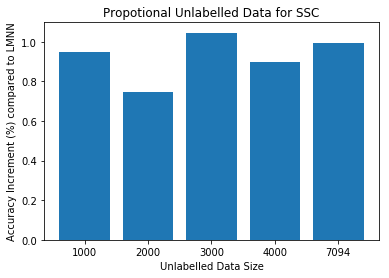

In [54]:
norm_accs=np.array(acc_list) - base_acc
x=np.arange(len(norm_accs))
fig, ax = plt.subplots()
plt.bar(x, norm_accs*100)
plt.xticks(x, unlabel_sizes)
plt.xlabel('Unlabelled Data Size')
plt.ylabel('Accuracy Increment (%) compared to LMNN')
plt.title('Propotional Unlabelled Data for SSC')
plt.show()

***
## 2.  Experinment 2 - MNIST data 

In [55]:
mnist = fetch_mldata('MNIST original', data_home='ml_data/mnist')  #Download MMNIST

In [56]:
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [57]:
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=4000)
X_train_unlabelled=new_X_train[sample_inds, :]

print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4
k, omega = (4, 0.3)
k, omega0, omega1, omega2 =(4, 0.4, 0.2, 0.8)


print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("MNIST KNN : ",  neigh.score(X_test,y_test))

lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega)
lmnn.fit(X_train_labelled,y_train_labelled)
print("MNIST LMNN : ", lmnn.score(X_test,y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled)
ssc.fit(X_train_labelled, y_train_labelled)
print("MNIST SSC : ", ssc.score(X_test,y_test))

('######## Performance Test:  Labelled = ', (200, 784), '  ###  Unlabelled = ', (4000, 784), '###########')
('########  K = ', 4, ' ###########')
('MNIST KNN : ', 0.75)
('MNIST LMNN : ', 0.75)
('MNIST SSC : ', 0.7501428571428571)


In [60]:
k, omega = (4, 0.5)
k, omega0, omega1, omega2 =(4, 0.5, 0.5, 0.5)
lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega)
lmnn.fit(X_train_labelled,y_train_labelled)
base_acc=lmnn.score(X_test,y_test)
print "label size: 200 MNIST SSC : ", base_acc

acc_list=list()    
unlabel_sizes=[1000,2000,3000,4000,new_X_train.shape[0]]

for unlabel_size in unlabel_sizes:
    
    sample_inds=np.random.randint(new_X_train.shape[0], size=unlabel_size)
    X_train_unlabelled=new_X_train[sample_inds, :]
    ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled)
    ssc.fit(X_train_labelled, y_train_labelled)
    acc= ssc.score(X_test,y_test)
    acc_list.append(acc)
    print "Unlabel size: ", unlabel_size," MNIST SSC : ", acc

label size: 200 MNIST SSC :  0.75
Unlabel size:  1000  MNIST SSC :  0.7500571428571429
Unlabel size:  2000  MNIST SSC :  0.7501714285714286
Unlabel size:  3000  MNIST SSC :  0.7501142857142857
Unlabel size:  4000  MNIST SSC :  0.7501428571428571
Unlabel size:  34800  MNIST SSC :  0.7501428571428571


## 3. Experiment - Sign Language Digits  https://www.kaggle.com/ardamavi/sign-language-digits-dataset/version/2

<img src="ml_data/SignLanguage.JPG">

In [2]:
X = np.load('ml_data/Sign-language-digits-dataset/X.npy')
Y = np.load('ml_data/Sign-language-digits-dataset/Y.npy')
X = X.reshape((X.shape[0], X.shape[1]**2))
Y = np.argwhere(Y == 1)[:,1]

# sample into train and test datasets
train_test_sample_inds=np.random.randint(X.shape[0], size=100)

X_test = X[train_test_sample_inds]
y_test = Y[train_test_sample_inds]

X_train = np.delete(X, train_test_sample_inds,0)
y_train = np.delete(Y, train_test_sample_inds,0)


######## Sample label, unlabel set  from training #########
# keeping 1 to 20 ration of unlabeled to laneled data
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds,:]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=4000)
X_train_unlabelled=new_X_train[sample_inds,:]

In [ ]:
sample_inds=np.random.randint(X_train.shape[0], size=200)
X_train_labelled=X_train[sample_inds, :]
y_train_labelled=y_train[sample_inds]

new_X_train = np.delete(X_train, sample_inds,0)
new_y_train = np.delete(y_train, sample_inds,0)

sample_inds=np.random.randint(new_X_train.shape[0], size=4000)
X_train_unlabelled=new_X_train[sample_inds, :]

print("######## Performance Test:  Labelled = ",X_train_labelled.shape, "  ###  Unlabelled = ", X_train_unlabelled.shape, "###########")
k=4
k, omega = (4, 0.3)
k, omega0, omega1, omega2 =(4, 0.4, 0.2, 0.8)


print("########  K = ",k, " ###########")

neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train_labelled,y_train_labelled)
print("HANDS KNN : ",  neigh.score(X_test,y_test))

lmnn = LargeMarginNearestNeighbor(n_neighbors=k,omega=omega)
lmnn.fit(X_train_labelled,y_train_labelled)
print("HANDS LMNN : ", lmnn.score(X_test,y_test))

ssc = SemiSupervisedLargeMarginNearestNeighbor(n_neighbors=k, omega0=omega0, omega1=omega1, omega2=omega2,X_unlabeled=X_train_unlabelled)
ssc.fit(X_train_labelled, y_train_labelled)
print("HANDS SSC : ", ssc.score(X_test,y_test))

('######## Performance Test:  Labelled = ', (200, 4096), '  ###  Unlabelled = ', (4000, 4096), '###########')
('########  K = ', 4, ' ###########')
('HANDS KNN : ', 0.48)
